# Import Dependencies

In [1]:
%pip install cdlib scikit-learn pandas plotly hvplot community python-louvain dynetx seaborn
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('./lib')

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from visualization import visualize_disconnected_communities, visualize_hierarchical_communities
from utils import modified_rand_score, evaluate_level1_communities, evaluate_level2_communities, format_results, generate_missing_row

import networkx as nx
import dynetx as dn

from cdlib import algorithms, evaluation
import csv
import numpy as np
import pandas as pd
import os
import seaborn as sns

from sklearn.metrics import rand_score
from sklearn.metrics import adjusted_rand_score


from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.spatial import distance

from networkx.algorithms import approximation
from networkx.algorithms.community.quality import modularity
from networkx.algorithms.centrality import closeness_centrality
from cdlib import NodeClustering
from matplotlib.patches import FancyArrowPatch

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

from sklearn.metrics import pair_confusion_matrix
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

import colorsys
import random

Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'infomap', 'bayanpy', 'graph_tool', 'wurlitzer'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'infomap', 'wurlitzer'}


# Level 2 Network Formation

We employ the value-based construction with a delta of 0.85.

In [3]:
# Load the dataset
file_path = "../dataset/cho-170/cho-170.txt"
df = pd.read_csv(file_path, sep="\t")

# Extract relevant columns
genes = df["Gene"]
level_1_classes = df["Level_1"]
level_2_classes = df["Level_2"]
expression_data = df.iloc[:, 3:].values  # Extract time-series expression data

# Compute Pearson correlation matrix
correlation_matrix = np.corrcoef(expression_data)

# Threshold for value-based graph construction
delta_values = np.arange(0.1, 1, 0.05)  # Adjust delta values as needed

# Initialize array to store results for each delta value
results = []

for delta in delta_values:
    threshold = delta
    adjacency_matrix = (correlation_matrix >= threshold ).astype(int)

    # Create a graph
    G = nx.Graph()

    # Add nodes with Level 1 classification as attributes
    for idx, gene in enumerate(genes):
        G.add_node(idx, level_1=level_1_classes[idx], level_2=level_2_classes[idx])

    # Add edges based on Pearson correlation threshold
    edges = []
    for i in range(len(genes)):
        for j in range(i + 1, len(genes)):
            if adjacency_matrix[i, j] == 1:
                G.add_edge(i, j, weight=correlation_matrix[i, j])

    # Remove singletons
    singletons = list(nx.isolates(G))
    G.remove_nodes_from(singletons)

    # Compute additional graph properties
    avg_degree = sum(dict(G.degree()).values()) / len(G.nodes())  # Average degree
    density = nx.density(G)  # Graph density
    avg_clustering = nx.average_clustering(G)  # Average clustering coefficient
    largest_cc = max(nx.connected_components(G), key=len)  # Largest connected component
    largest_cc_size = len(largest_cc)  # Size of the largest component
    diameter = nx.diameter(G.subgraph(largest_cc)) if nx.is_connected(G) else None  # Diameter

    # Store results for the current delta, including the graph
    results.append({
			"Delta": delta,
			"Graph": G,  # Store the graph object
			"Number of Nodes": len(G.nodes()),
			"Number of Edges": G.number_of_edges(),
			"Transitivity": nx.transitivity(G) if len(G.nodes()) > 0 else 0,
			"Singletons Removed": len(singletons),
			"Average Degree": avg_degree,
			"Density": density,
			"Average Clustering Coefficient": avg_clustering,
			"Largest Component Size": largest_cc_size,
			"Diameter (if connected)": diameter
    })

# Convert results to a DataFrame for visualization (excluding the graph object)
graph_properties = pd.DataFrame([{k: v for k, v in result.items() if k != "Graph"} for result in results])
output_dir = "../results/cho-170"
if not os.path.exists(output_dir):
	os.makedirs(output_dir)

# Save graph properties to a CSV file
graph_properties.to_csv(f"{output_dir}/graph_properties.csv", index=False)
graph_properties

Delta  Number of Nodes  Number of Edges  Transitivity  Singletons Removed  \
0    0.10              170             7090      0.792473                   0   
1    0.15              170             6700      0.795263                   0   
2    0.20              170             6300      0.799007                   0   
3    0.25              170             5909      0.801900                   0   
4    0.30              170             5537      0.806284                   0   
5    0.35              170             5163      0.811426                   0   
6    0.40              170             4795      0.820075                   0   
7    0.45              169             4446      0.826850                   1   
8    0.50              169             4101      0.828420                   1   
9    0.55              169             3741      0.827669                   1   
10   0.60              169             3309      0.820863                   1   
11   0.65              167             2897      0.807264                   3   
12   0.70              166             2443      0.786777                   4   
13   0.75              164             1948      0.764272                   6   
14   0.80              154             1411      0.718146                  16   
15   0.85              132              866      0.654524                  38   
16   0.90              105              394      0.584388                  65   
17   0.95               42               69      0.502994                 128   

    Average Degree   Density  Average Clustering Coefficient  \
0        83.411765  0.493561                        0.773451   
1        78.823529  0.466411                        0.772134   
2        74.117647  0.438566                        0.772801   
3        69.517647  0.411347                        0.771324   
4        65.141176  0.385451                        0.773518   
5        60.741176  0.359415                        0.776482   
6        56.411765  0.333797                        0.782999   
7        52.615385  0.313187                        0.780004   
8        48.532544  0.288884                        0.777632   
9        44.272189  0.263525                        0.774676   
10       39.159763  0.233094                        0.763228   
11       34.694611  0.209004                        0.745895   
12       29.433735  0.178386                        0.718217   
13       23.756098  0.145743                        0.693998   
14       18.324675  0.119769                        0.653067   
15       13.121212  0.100162                        0.586662   
16        7.504762  0.072161                        0.445419   
17        3.285714  0.080139                        0.283569   

    Largest Component Size  Diameter (if connected)  
0                      170                      3.0  
1                      170                      3.0  
2                      170                      3.0  
3                      170                      3.0  
4                      170                      3.0  
5                      170                      4.0  
6                      170                      4.0  
7                      169                      5.0  
8                      169                      5.0  
9                      169                      5.0  
10                     169                      6.0  
11                     167                      7.0  
12                     166                      8.0  
13                     164                     10.0  
14                     101                      NaN  
15                      85                      NaN  
16                      57                      NaN  
17                      23                      NaN

# Level 2 Network Visualization (Level 1 Coloring)

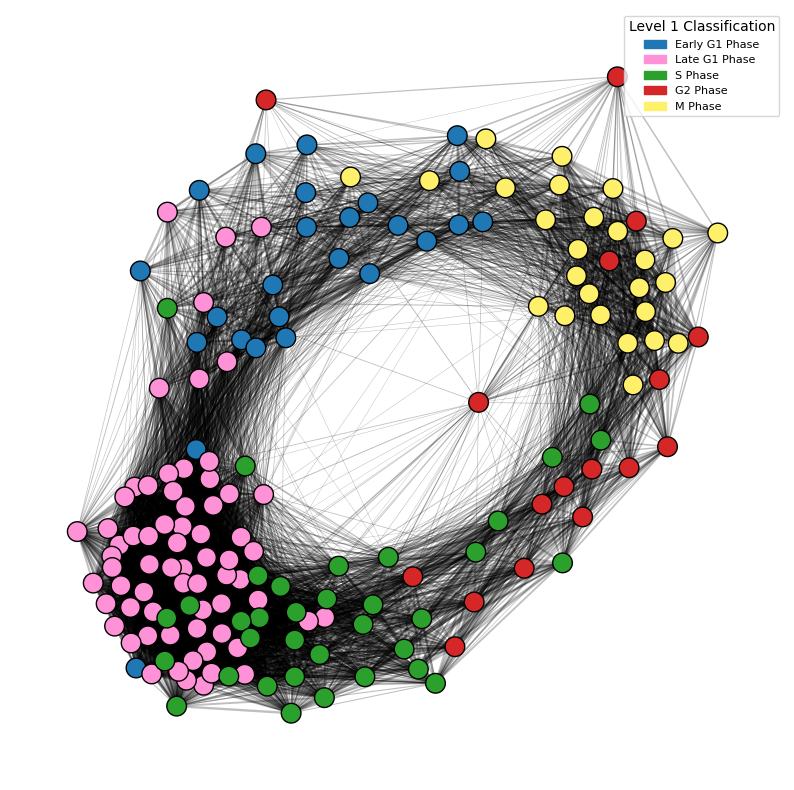

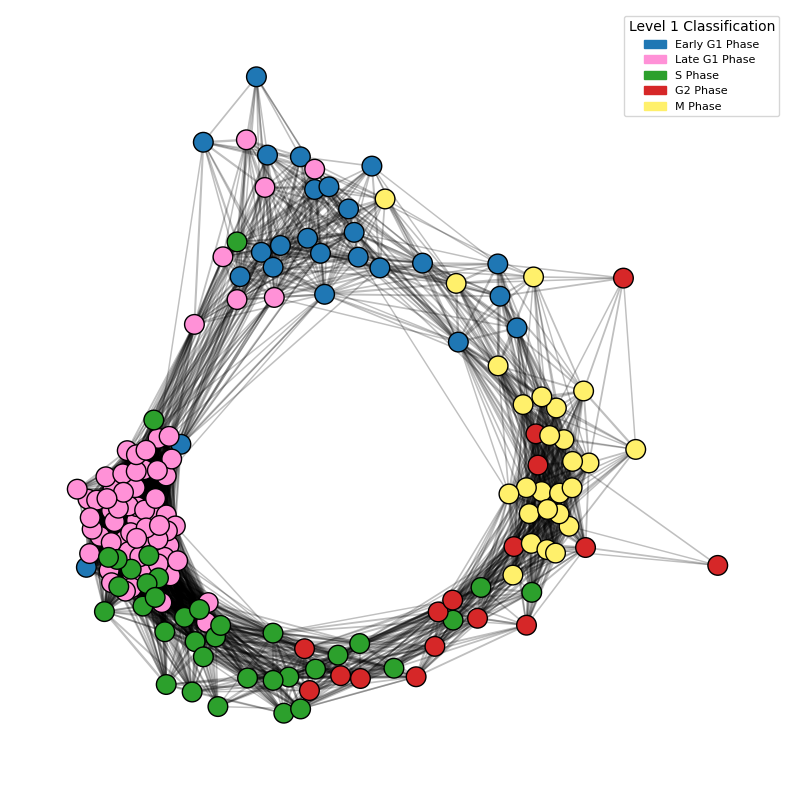

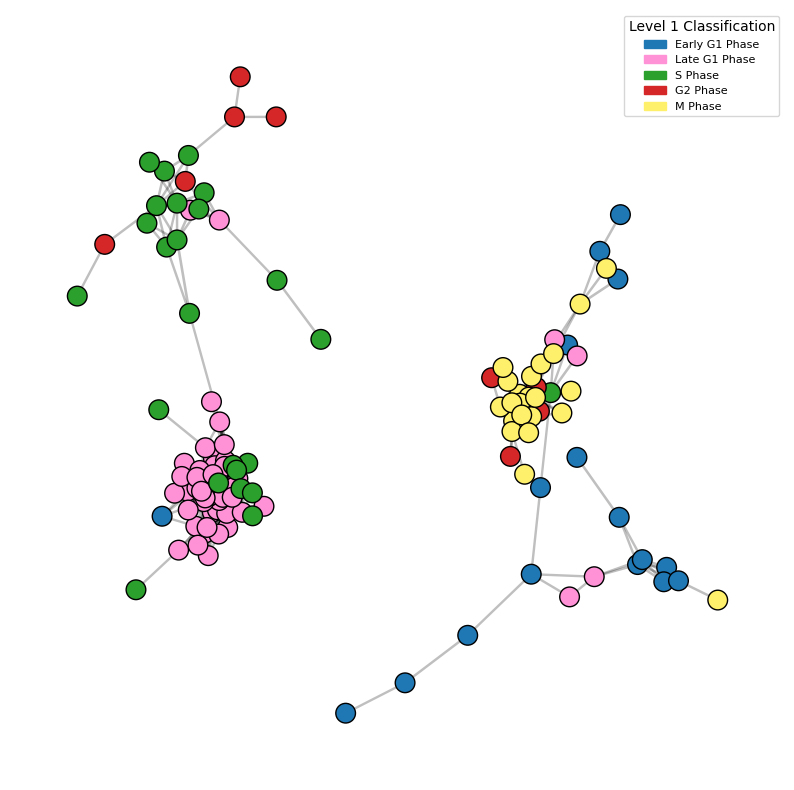

In [4]:
TABLEAU_COLORS = {
    'tab:blue': '#1f77b4',
    'tab:pink': '#ff91d7',
    'tab:green': '#2ca02c',
    'tab:red': '#d62728',
    'tab:yellow': '#fff06b',
}
# Define unique colors for each Level 1 classification
unique_classes = level_1_classes.unique()
color_map = {cls: TABLEAU_COLORS[list(TABLEAU_COLORS.keys())[i]] for i, cls in enumerate(unique_classes)}

G_015 = results[1]["Graph"]  # Choose the graph with delta = 0.15
G_05 = results[8]["Graph"]  # Choose the graph with delta = 0.5
G_085 = results[15]["Graph"]  # Choose the graph with delta = 0.85
graphs = [G_015, G_05, G_085]

for G, delta_value in zip(graphs, [0.15, 0.5, 0.85]):
    # Assign colors to nodes based on Level 1 classification
    node_colors = [color_map[G.nodes[n]["level_1"]] for n in G.nodes()]

    # Edge weights for visualization (stronger edges appear tighter)
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

    # Generate graph layout
    plt.figure(figsize=(10, 10))
    cell_cycle_phases = ["Early G1 Phase", "Late G1 Phase", "S Phase", "G2 Phase", "M Phase"]
    legend_handles = [Patch(color=color, label=f'{cell_cycle_phases[cls-1]}') for cls, color in color_map.items()]
    plt.legend(handles=legend_handles, loc="best", fontsize=8, title="Level 1 Classification")
    pos = nx.spring_layout(G, weight='weight', k=0.1, seed=10)  # Spring layout based on weights

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=200, alpha=1, edgecolors="black")

    # Draw edges with thickness based on weight
    nx.draw_networkx_edges(G, pos, alpha=0.25, edge_color="black", width=[w * 2 for w in edge_weights])

    # Show plot
    # plt.title(f"Cho Gene Co-Expression Network Level 1 Visualization (Value-Based, δ = {delta_value})")
    plt.axis("off")
    plt.show()

# Level 2 Network Visualization (Level 2 Classification)

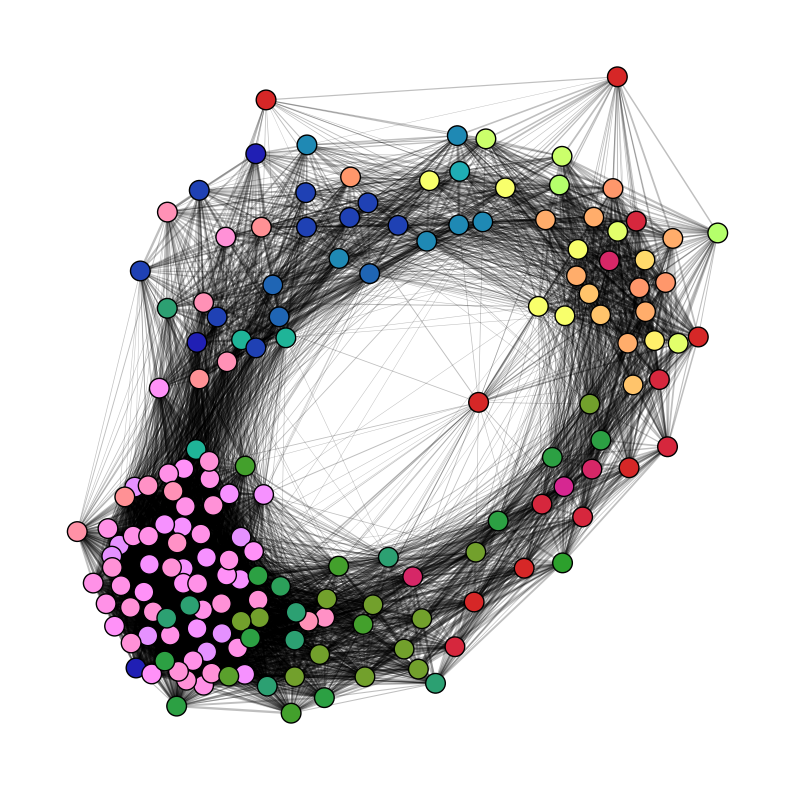

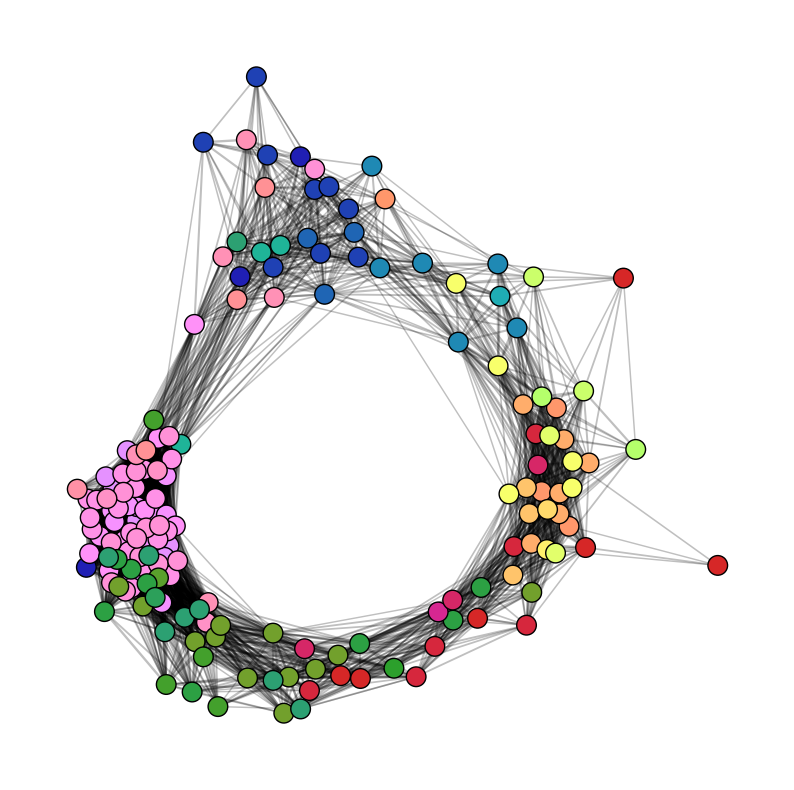

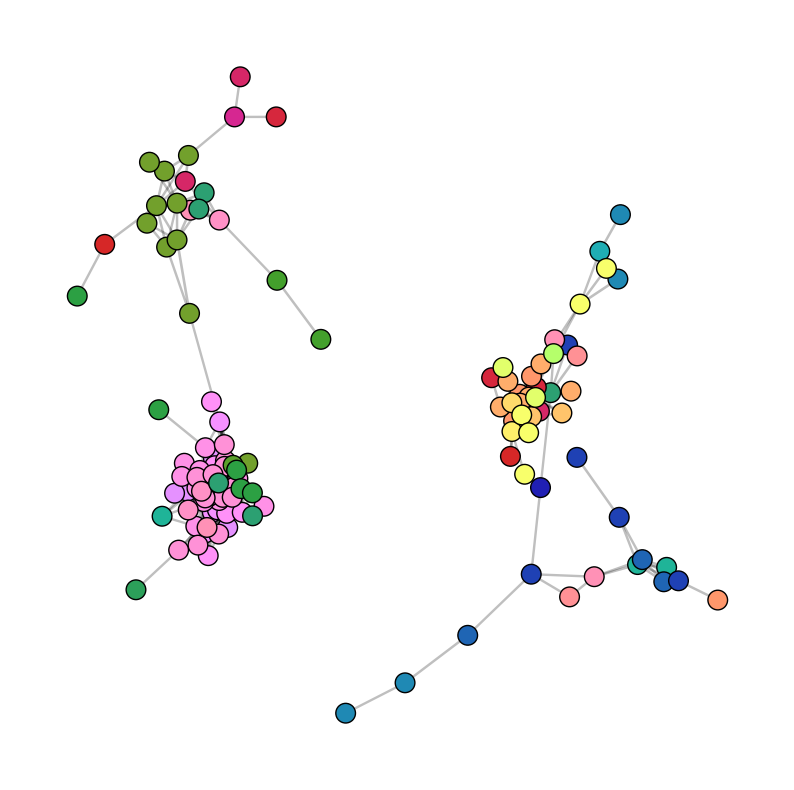

In [5]:
base_colors = {cls: TABLEAU_COLORS[list(TABLEAU_COLORS.keys())[i]]
               for i, cls in enumerate(unique_classes)}

# Function to generate distinct but related colors for Level 2 classifications
def generate_hue_variations(base_color, num_shades):
    """Generate distinct hues within a color family using HSL space."""
    base_rgb = mcolors.to_rgb(base_color)
    base_hls = colorsys.rgb_to_hls(*base_rgb)
    
    # Create variations by adjusting only the HUE component
    hues = np.linspace(base_hls[0] - 0.1, base_hls[0] + 0.1, num_shades)
    hues = np.clip(hues, 0, 1)  # Ensure hues are within valid range
    
    return [mcolors.to_hex(colorsys.hls_to_rgb(hue, base_hls[1], base_hls[2])) for hue in hues]

# Generate Level 2 colors based on hue variations within the Level 1 color family
level_2_groups = df.groupby("Level_1")["Level_2"].unique()
level_2_colors = {}

for lvl1, lvl2_values in level_2_groups.items():
    shades = generate_hue_variations(base_colors[lvl1], len(lvl2_values))
    for idx, lvl2 in enumerate(lvl2_values):
        level_2_colors[lvl2] = shades[idx]

# Iterate through the graphs for different delta values
for G, delta_value in zip(graphs, [0.15, 0.5, 0.85]):
    # Assign colors to nodes based on Level 2 classification
    node_colors_level_2 = [level_2_colors[G.nodes[n]["level_2"]] for n in G.nodes()]

    # Edge weights for visualization
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

    # Generate graph layout
    plt.figure(figsize=(10, 10))
    legend_handles_lvl2 = [Patch(color=color, label=f'Level 2: {cls}') for cls, color in level_2_colors.items()]
    # plt.legend(handles=legend_handles_lvl2, loc="best", fontsize=6, title="Level 2 Classification")

    pos = nx.spring_layout(G, weight='weight', k=0.1, seed=10)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors_level_2, node_size=200, alpha=1, edgecolors="black")

    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.25, edge_color="black", width=[w * 2 for w in edge_weights])

    # Show plot
    # plt.title(f"Cho Gene Co-Expression Network Level 2 Visualization (Value-Based, δ = {delta_value})")
    plt.axis("off")
    plt.show()


# Community Detection Auxiliary Functions

These are the functions used during the Community Detection of our constructed network.

In [6]:
def evaluate_community(G_subgraph, communities, delta):
	num_communities = len(communities.communities)
	largest_community_size = max(len(c) for c in communities.communities)
	community_sizes = [len(c) for c in communities.communities]
	num_singletons = sum(1 for c in communities.communities if len(c) == 1)
	modularity_score = evaluation.newman_girvan_modularity(G_subgraph, communities).score

	community_centralities = []
	for community in communities.communities:
		if len(community) > 1:
			subgraph = G_subgraph.subgraph(community)
			centralities = nx.closeness_centrality(subgraph).values()
			community_centralities.extend(centralities)
	avg_closeness_centrality = np.mean(community_centralities) if community_centralities else 0.0

	predicted_labels_dict = {node: -1 for node in G_subgraph.nodes()}
	for i, community in enumerate(communities.communities):
		for node in community:
			predicted_labels_dict[node] = i
	predicted_labels = [predicted_labels_dict[node] for node in G_subgraph.nodes()]

	true_labels_level_1 = [G_subgraph.nodes[n]["level_1"] for n in G_subgraph.nodes()]
	true_labels_level_2 = [G_subgraph.nodes[n]["level_2"] for n in G_subgraph.nodes()]
	# ARI/RI/MRI
	ari_score1 = adjusted_rand_score(true_labels_level_1, predicted_labels)
	ari_score2 = adjusted_rand_score(true_labels_level_2, predicted_labels)
	ri_score1 = rand_score(true_labels_level_1, predicted_labels)
	ri_score2 = rand_score(true_labels_level_2, predicted_labels)
	
	nodes_true_list = list(G_subgraph.nodes())
	nodes_pred_list = [node for community in communities.communities for node in community]
	mri_score1 = modified_rand_score(true_labels_level_1, predicted_labels, nodes_true_list, nodes_pred_list)
	mri_score2 = modified_rand_score(true_labels_level_2, predicted_labels, nodes_true_list, nodes_pred_list)
	return pd.DataFrame({
			"Delta": [delta],
			"Number of Communities": [num_communities],
			"Nodes in Largest Community": [largest_community_size],
			"Community Sizes": [community_sizes],
			"Singletons": [num_singletons],
			"Modularity": [modularity_score],
			"Closeness Centrality": [avg_closeness_centrality],
			"ARI (Level 1)": [ari_score1],
			"ARI (Level 2)": [ari_score2],
			"RI (Level 1)": [ri_score1],
			"RI (Level 2)": [ri_score2],
			# "MRI (Level 1)": [mri_score1],
			# "MRI (Level 2)": [mri_score2],
			"Communities": [communities.communities]
	})

# Special Function for Paris
We need to have a special function for Paris, since we need to relabel nodes so it doesn't conflict with the built in functions in cdlib (it does not support int node labels)

In [7]:
def apply_paris(G):
    G_for_paris = nx.relabel_nodes(G, lambda x: f"n{x}", copy=True)
    paris_communities = algorithms.paris(G_for_paris)

    original_labels = list(G.nodes())
    label_map = {f"n{node}": node for node in original_labels}

    remapped_communities = [
        [int(n[1:]) for n in community]
        for community in paris_communities.communities
    ]

    paris_communities_fixed = NodeClustering(
        communities=remapped_communities,
        graph=G,
        method_name="Paris"
    )
    return paris_communities_fixed

# Extracting 2nd Level Communities

In [8]:
def extract_second_level_communities(G, cd_algorithm, top_level_clustering: NodeClustering, method_name: str, alpha = None, level = 5):
    ordered_communities = []
    bottom_to_top_map = {}

    for top_idx, community_nodes in enumerate(top_level_clustering.communities):
        subgraph = G.subgraph(community_nodes).copy()
        if len(subgraph.nodes()) <= 3:
            continue

        # For Spinglass and similar, ensure it's connected
        if not nx.is_connected(subgraph):
            subgraph = subgraph.subgraph(max(nx.connected_components(subgraph), key=len)).copy()
            if len(subgraph.nodes()) <= 3:
                continue  # skip tiny LCCs

        if method_name == "Paris":
            sub_communities = apply_paris(subgraph)
        elif method_name == "LFM":
            sub_communities = cd_algorithm(subgraph, alpha=alpha)
        elif method_name == "GN":
            sub_communities = algorithms.girvan_newman(subgraph, level=level)
        else:
            sub_communities = cd_algorithm(subgraph)

        for sub_nodes in sub_communities.communities:
            ordered_communities.append(sub_nodes)
            bottom_to_top_map[len(ordered_communities) - 1] = top_idx

    bottom_level_clustering = NodeClustering(
        communities=ordered_communities,
        graph=G,
        method_name=method_name,
    )

    return ordered_communities, bottom_level_clustering, bottom_to_top_map

# Obtaining the Largest Connected Components in G of $\delta$ = 0.15, 0.5, and 0.85

In [9]:
largest_cc_nodes = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc_nodes).copy()

G_remaining = G.copy()
G_remaining.remove_nodes_from(largest_cc_nodes)
modified_graphs = {0.15: graphs[0], 0.5:graphs[1], 0.85:G_lcc}

# Hierarchical Community Detection

Using our formed network, we employ the Paris and LFM algorithms.

## Paris Algorithm

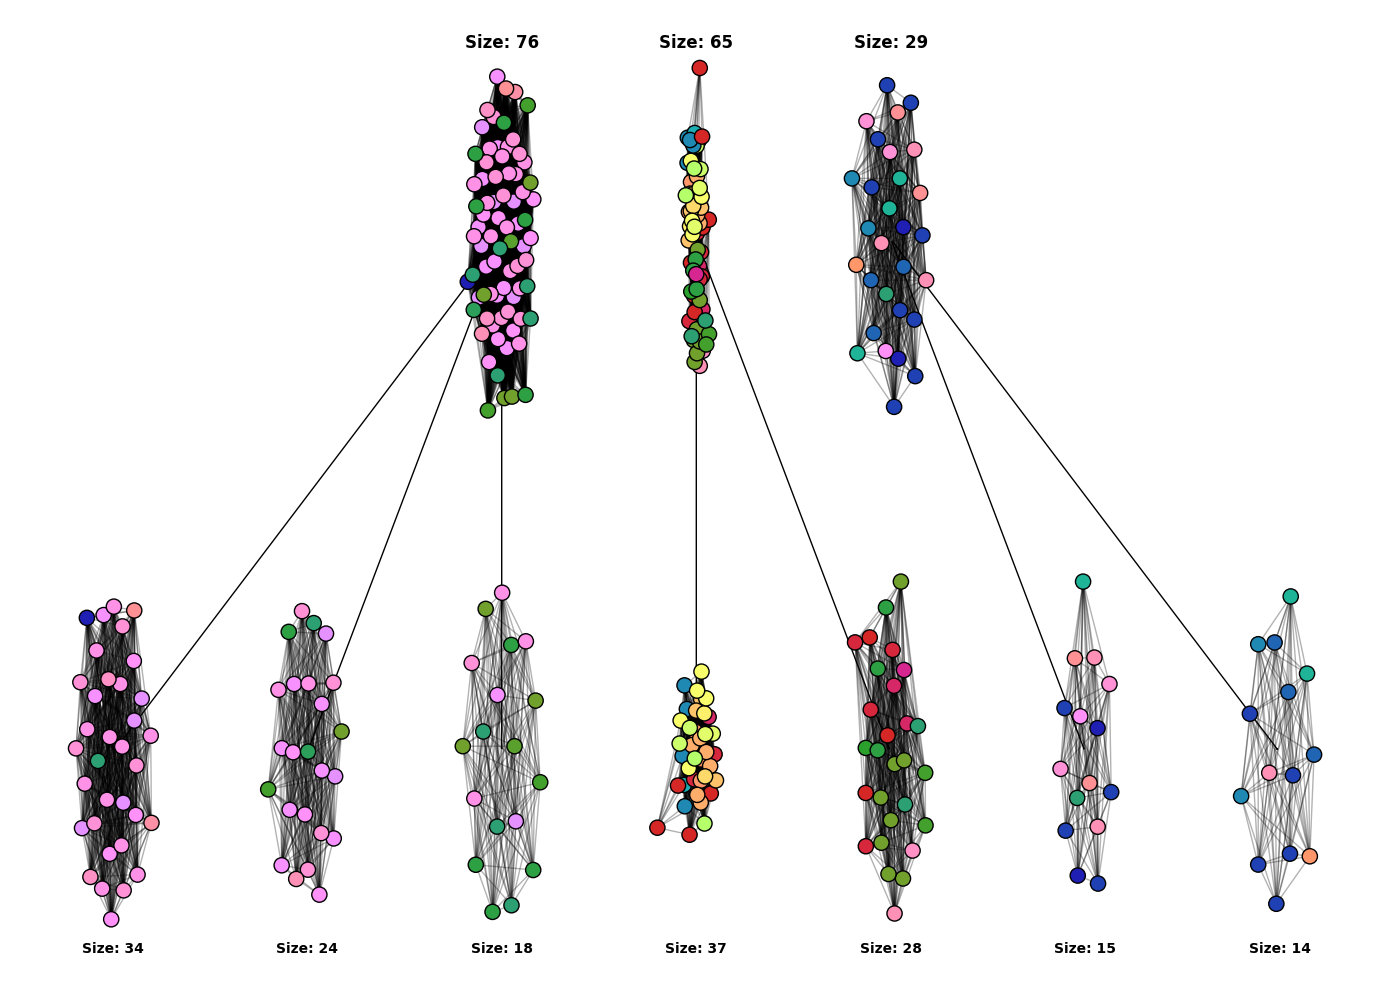

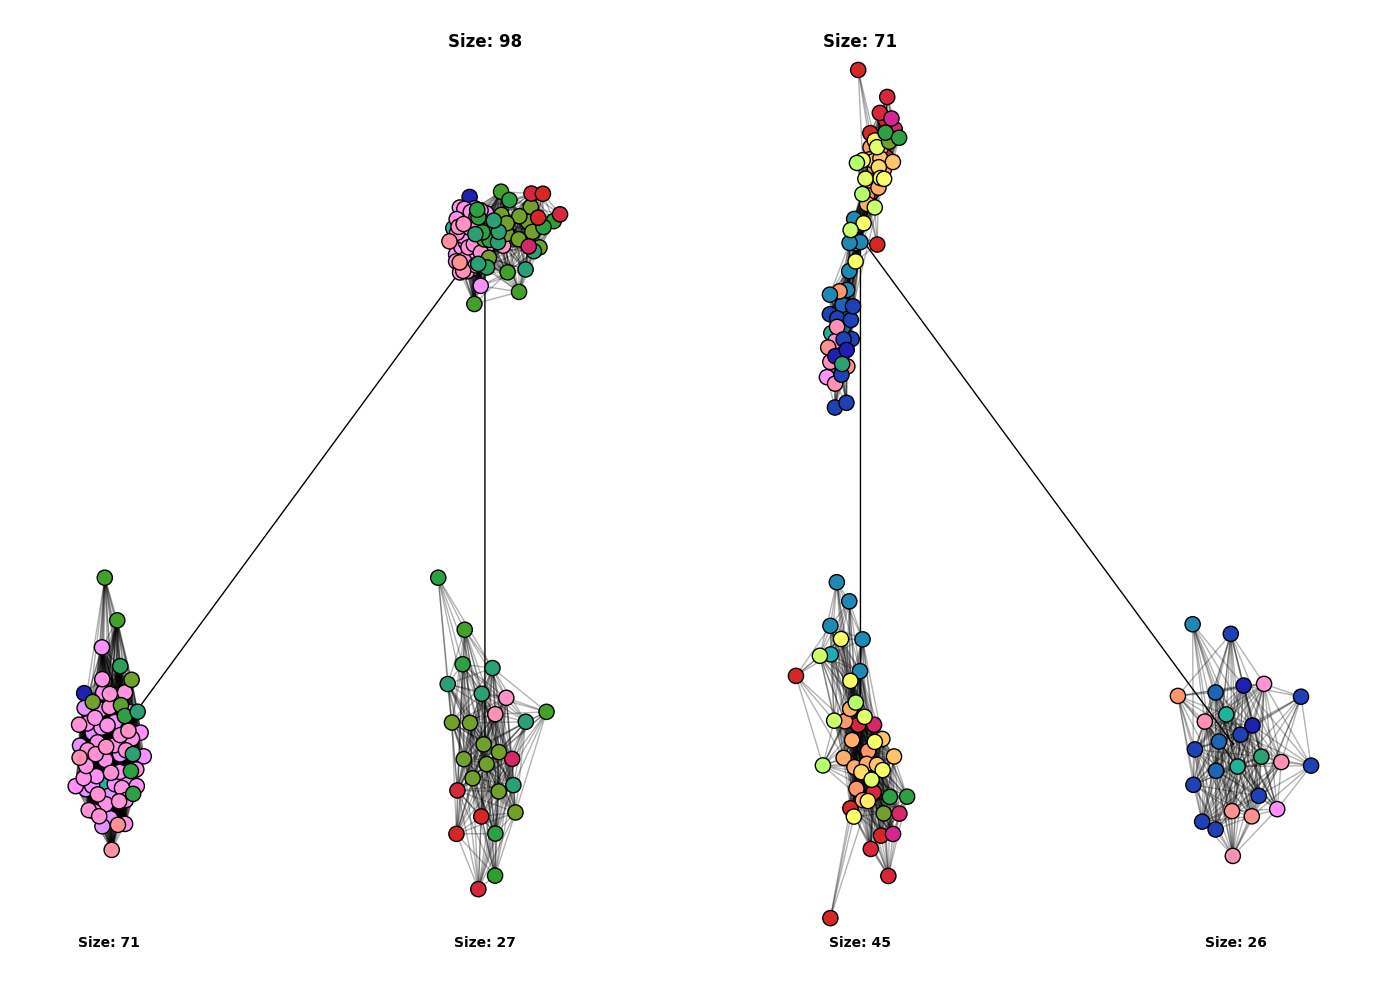

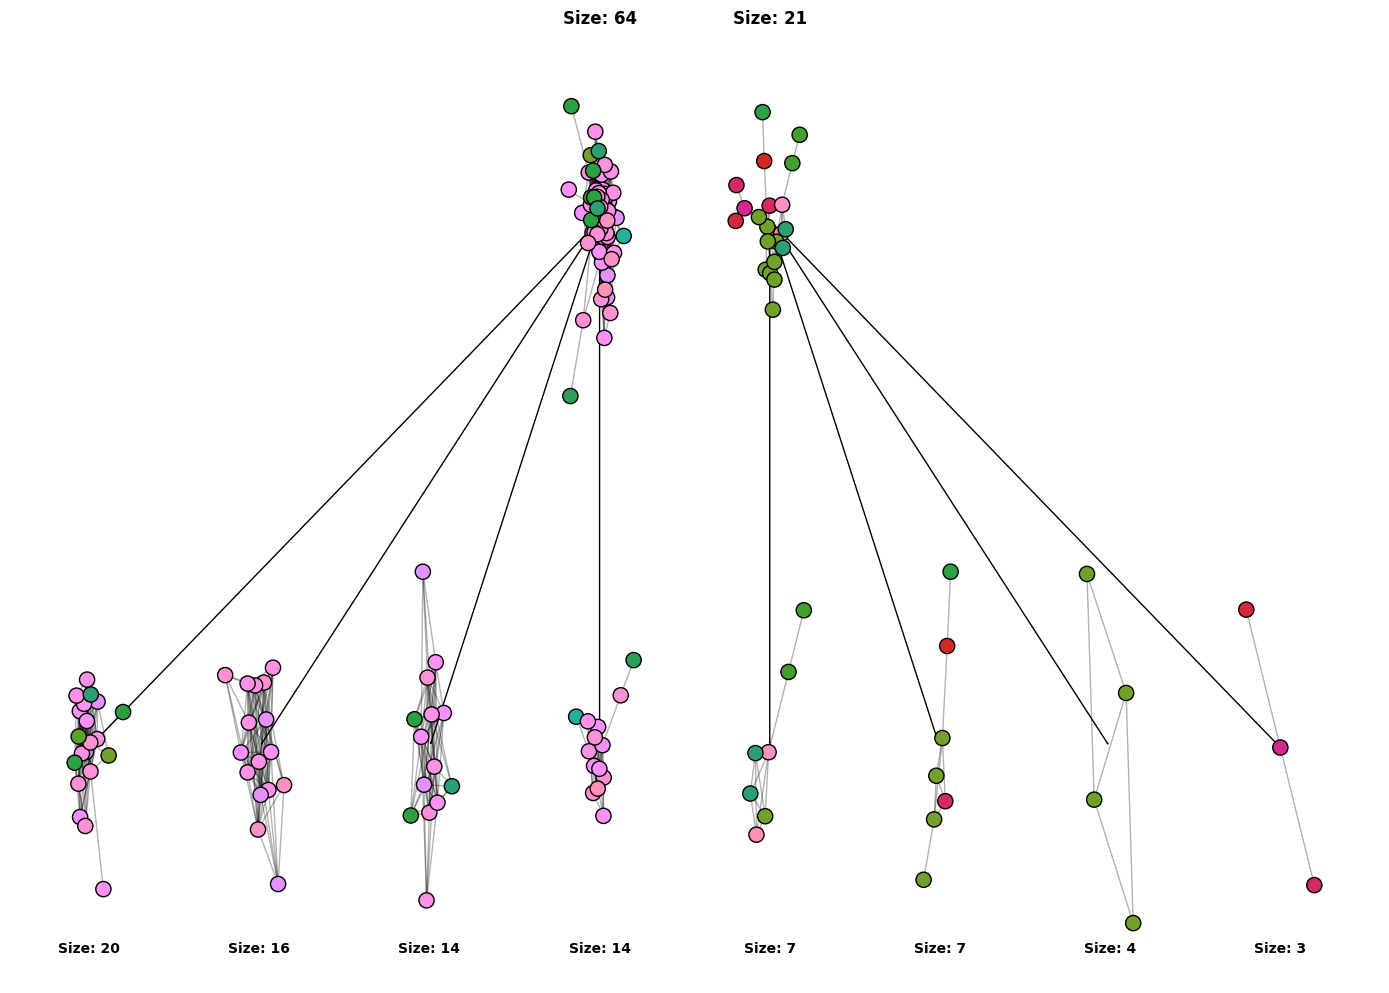

In [10]:
paris_results_list = []

for delta, graph in modified_graphs.items():
	# Run top-level community detection
	top_level_paris = apply_paris(graph)

	# Evaluate Level 1 communities
	eval_lvl1 = evaluate_level1_communities(delta, graph, top_level_paris)
	paris_results_list.append(eval_lvl1)

	# Extract Level 2 subcommunities
	bottom_level_communities_paris, bottom_level_clustering_paris, bottom_to_top_map_paris = extract_second_level_communities(
			graph, algorithms.paris, top_level_paris, "Paris"
	)

	# Evaluate Level 2 subcommunities
	eval_lvl2 = evaluate_level2_communities(delta, graph, bottom_level_clustering_paris)
	paris_results_list.append(eval_lvl2)

	visualize_hierarchical_communities(
		graph,
		top_level_communities=top_level_paris.communities.copy(),
		bottom_level_communities=bottom_level_communities_paris,
		bottom_to_top_map=bottom_to_top_map_paris,
		color_map=level_2_colors,
		color_by="level_2",
		title="",
	)

In [11]:
Paris_results_df = format_results(pd.concat(paris_results_list, ignore_index=True))
Paris_results_df

Level  Delta  Number of Communities  Nodes in Largest Community  \
0    L1   0.15                      3                          76   
1    L2   0.15                      7                          37   
2    L1   0.50                      2                          98   
3    L2   0.50                      4                          71   
4    L1   0.85                      2                          64   
5    L2   0.85                      8                          20   

                Community Sizes  Singletons  Modularity  Closeness Centrality  \
0                  [76, 65, 29]           0    0.321865              0.893293   
1  [37, 34, 28, 24, 18, 15, 14]           0    0.217234              0.980273   
2                      [98, 71]           0    0.317191              0.645101   
3              [71, 45, 27, 26]           0    0.386131              0.841718   
4                      [64, 21]           0    0.100972              0.528631   
5  [20, 16, 14, 14, 7, 7, 4, 3]           0    0.226944              0.726922   

   ARI (L1)   RI (L1)  ARI (L2)   RI (L2)  \
0  0.380619  0.730386       NaN       NaN   
1       NaN       NaN  0.125142  0.839958   
2  0.305660  0.649408       NaN       NaN   
3       NaN       NaN  0.128712  0.730628   
4  0.499594  0.750420       NaN       NaN   
5       NaN       NaN  0.074109  0.799440   

                                         Communities  
0  [[112, 63, 100, 78, 53, 125, 49, 115, 31, 102,...  
1  [[155, 163, 157, 158, 139, 143, 162, 144, 152,...  
2  [[78, 69, 32, 46, 34, 56, 38, 41, 85, 44, 71, ...  
3  [[53, 119, 69, 37, 35, 32, 57, 30, 34, 41, 56,...  
4  [[53, 72, 111, 79, 40, 28, 45, 62, 104, 110, 6...  
5  [[53, 72, 111, 79, 40, 28, 45, 62, 104, 110, 6...

## LFM Algorithm

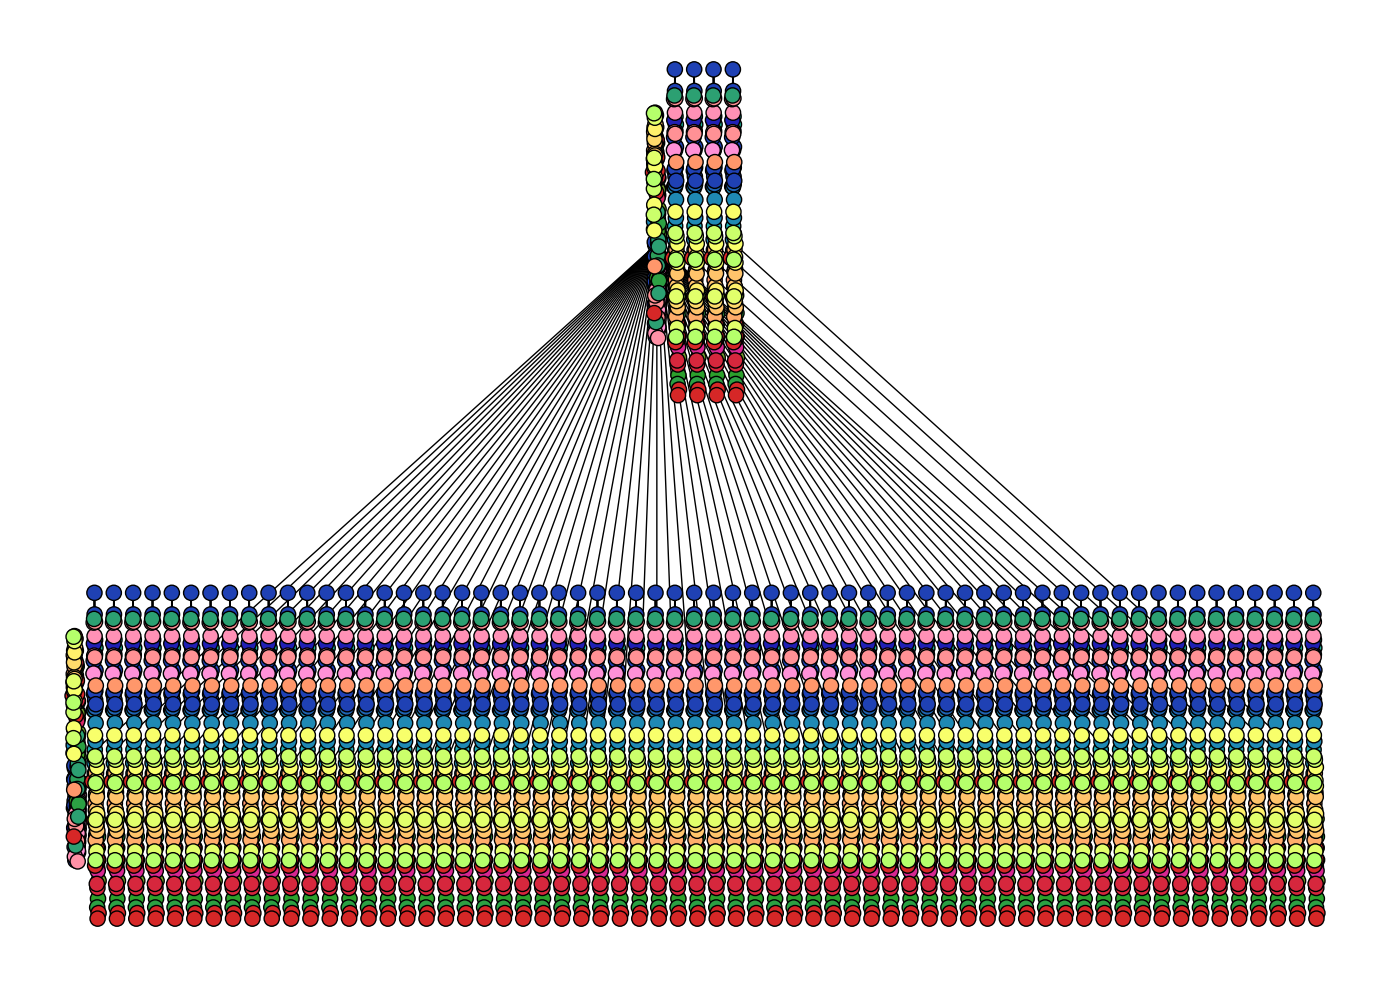

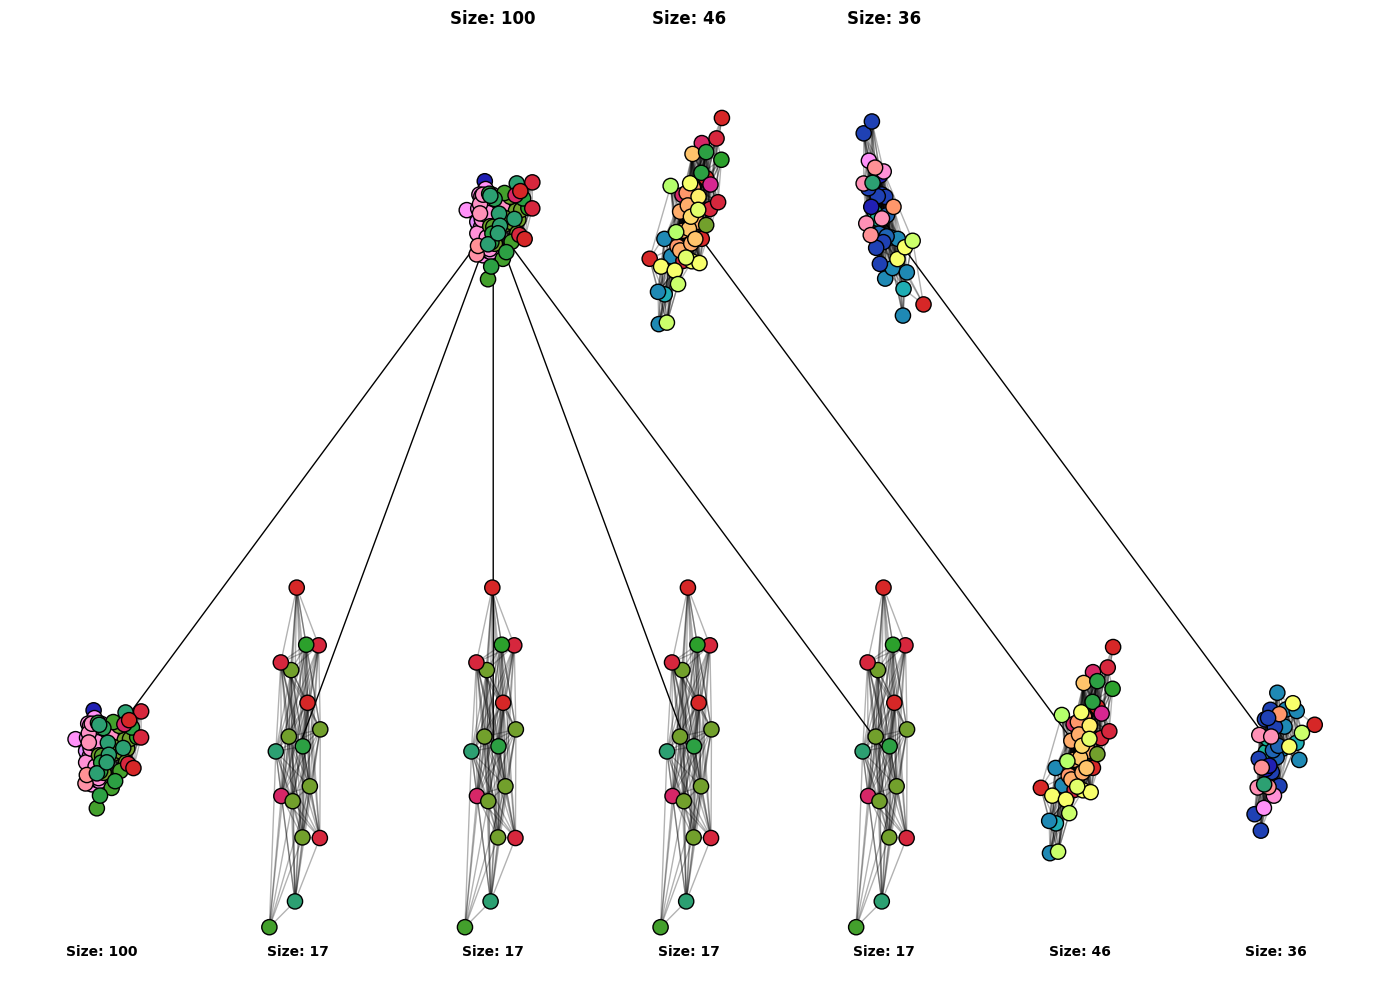

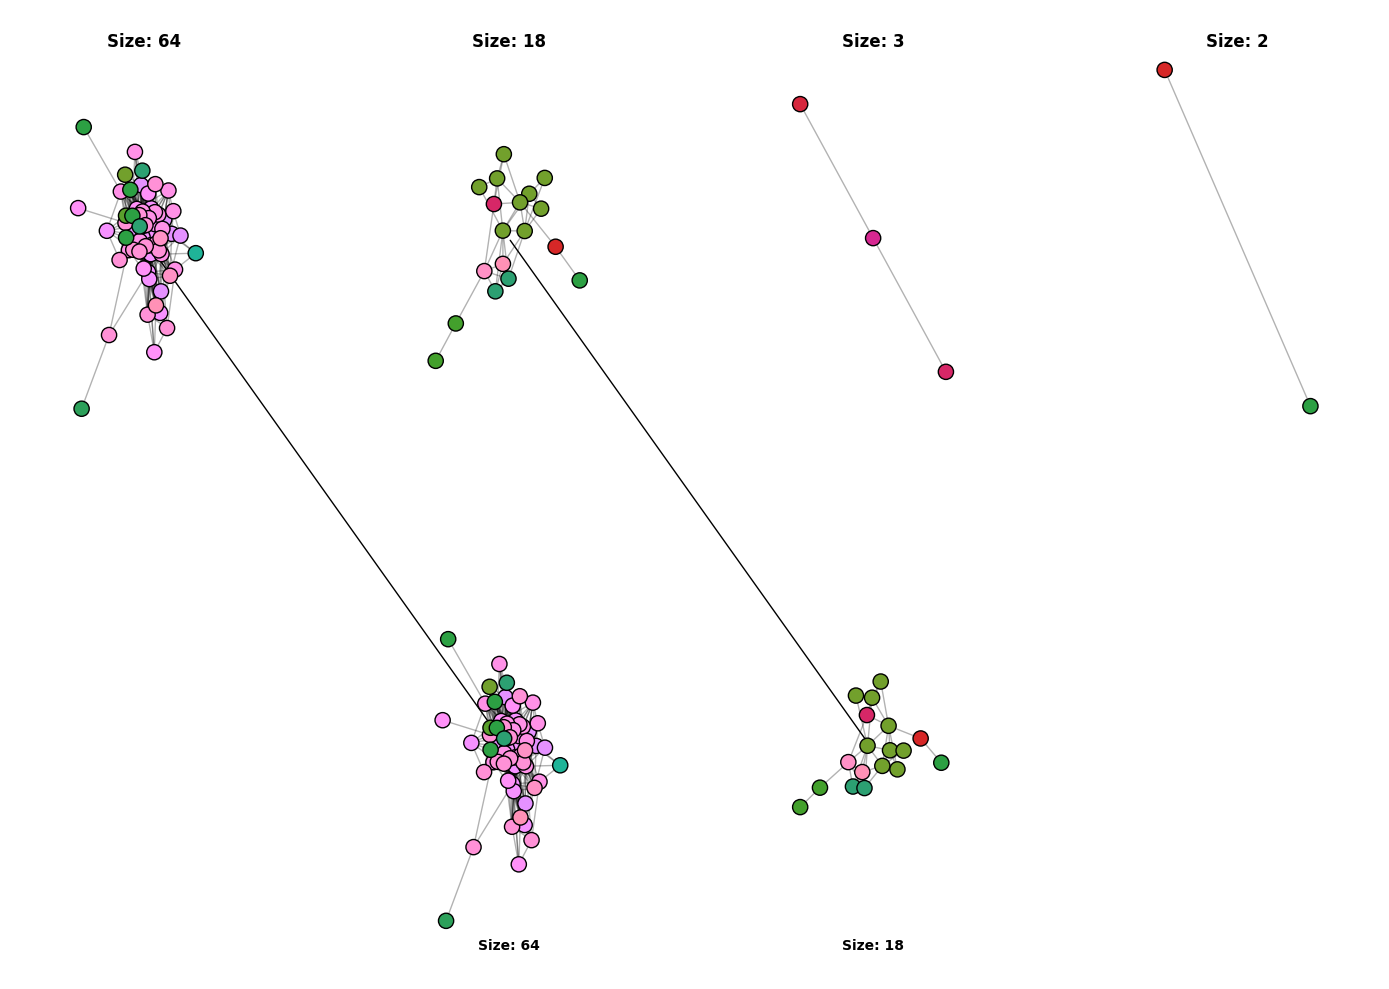

In [26]:
random.seed(42)
np.random.seed(42)

# alpha_values = np.arange(0.1, 1.0, 0.1)
alpha_values = [0.9]
lfm_results_list = []
lfm_communities = []
for idx, (delta, graph) in enumerate(modified_graphs.items()):
	for alpha in alpha_values:
		top_level_lfm = algorithms.lfm(graph, alpha=alpha)
		lfm_eval_lvl1 = evaluate_level1_communities(delta, graph, top_level_lfm)
		lfm_eval_lvl1.insert(2, "Alpha", alpha)
		lfm_results_list.append(lfm_eval_lvl1)

		# Extract Level 2 subcommunities
		bottom_level_communities_lfm, bottom_level_clustering_lfm, bottom_to_top_map_lfm = extract_second_level_communities(
			graph, algorithms.lfm, top_level_lfm, "LFM", alpha=alpha
		)
		
		# Evaluate Level 2 subcommunities
		lfm_eval_lvl2 = evaluate_level2_communities(delta, graph, bottom_level_clustering_lfm)
		lfm_eval_lvl2.insert(2, "Alpha", alpha)
		lfm_results_list.append(lfm_eval_lvl2)

		
		show_text = not (idx == 0)

		# Visualize hierarchical communities
		visualize_hierarchical_communities(
			graph,
			top_level_communities=top_level_lfm.communities.copy(),
			bottom_level_communities=bottom_level_communities_lfm,
			bottom_to_top_map=bottom_to_top_map_lfm,
			color_map=level_2_colors,
			color_by="level_2",
			title="",
			show_text=show_text
		)

In [13]:
LFM_results_df = format_results(pd.concat(lfm_results_list, ignore_index=True))
LFM_results_df

Level  Delta  Number of Communities  Nodes in Largest Community  \
0    L1   0.15                      5                         170   
1    L2   0.15                     65                         170   
2    L1   0.50                      3                         100   
3    L2   0.50                      7                         100   
4    L1   0.85                      4                          64   
5    L2   0.85                      2                          64   

                                     Community Sizes  Singletons  Modularity  \
0                              [170, 77, 77, 77, 77]           0    0.311106   
1  [170, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, ...           0    0.311106   
2                                      [100, 46, 36]           0    0.330139   
3                      [100, 46, 36, 17, 17, 17, 17]           0    0.364348   
4                                     [64, 18, 3, 2]           0    0.098890   
5                                           [64, 18]           0    0.096719   

   Closeness Centrality  ARI (L1)   RI (L1)  ARI (L2)   RI (L2)  \
0              0.674796  0.317005  0.657988       NaN       NaN   
1              0.693742       NaN       NaN  0.059602  0.528507   
2              0.706549  0.407319  0.729572       NaN       NaN   
3              0.757833       NaN       NaN  0.104169  0.694210   
4              0.565733  0.525659  0.763305       NaN       NaN   
5              0.547383       NaN       NaN  0.103435  0.472549   

                                         Communities  
0  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...  
1  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...  
2  [[2, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 3...  
3  [[2, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 3...  
4  [[2, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 3...  
5  [[2, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 3...

## Girvan Newman Algorithm

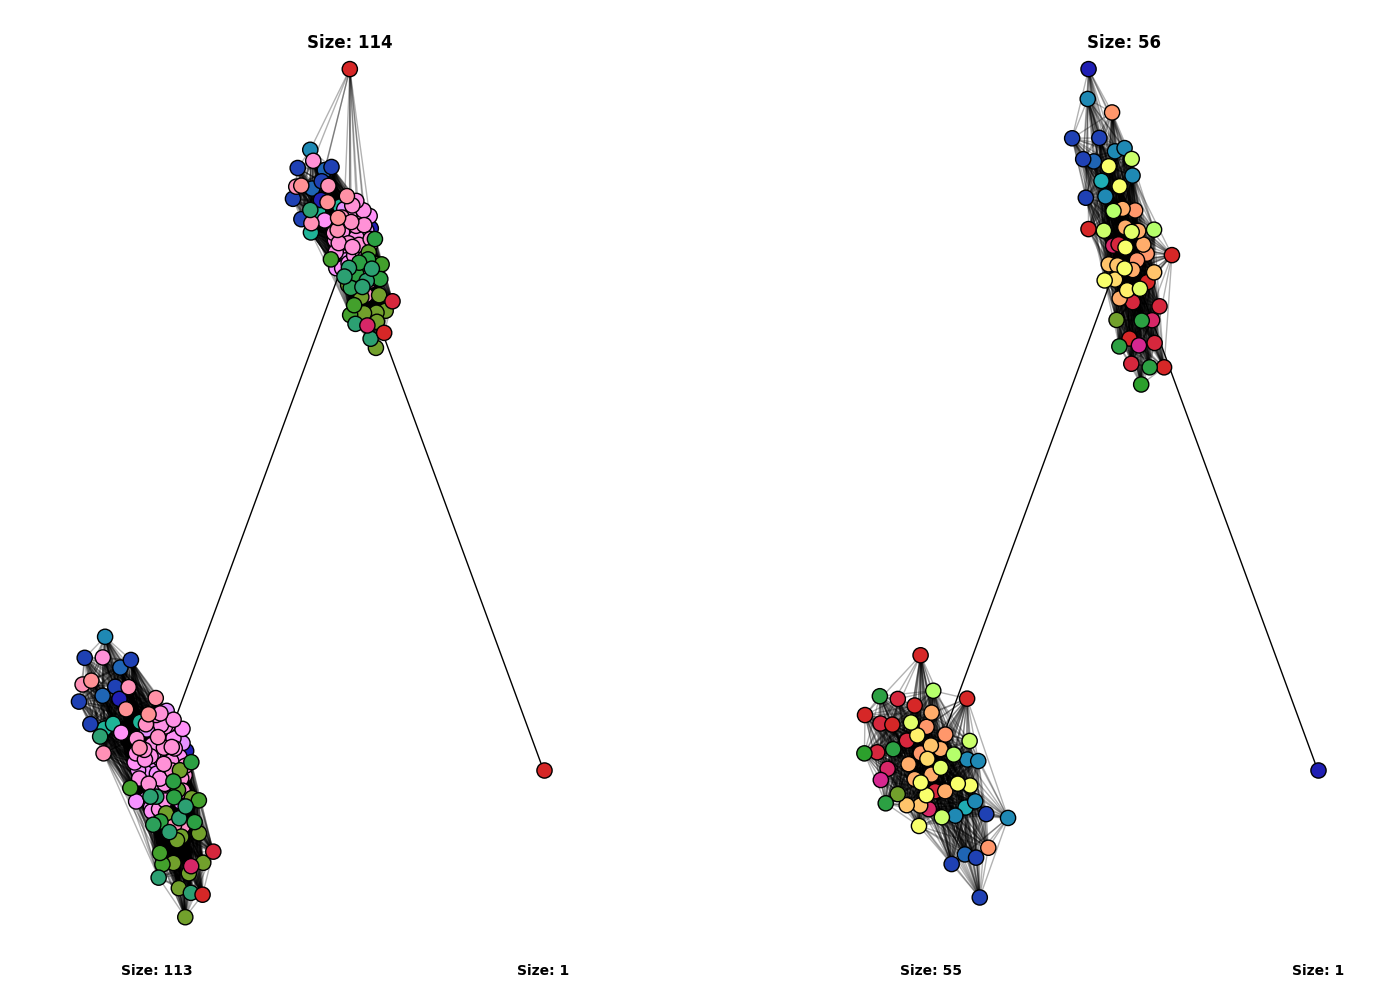

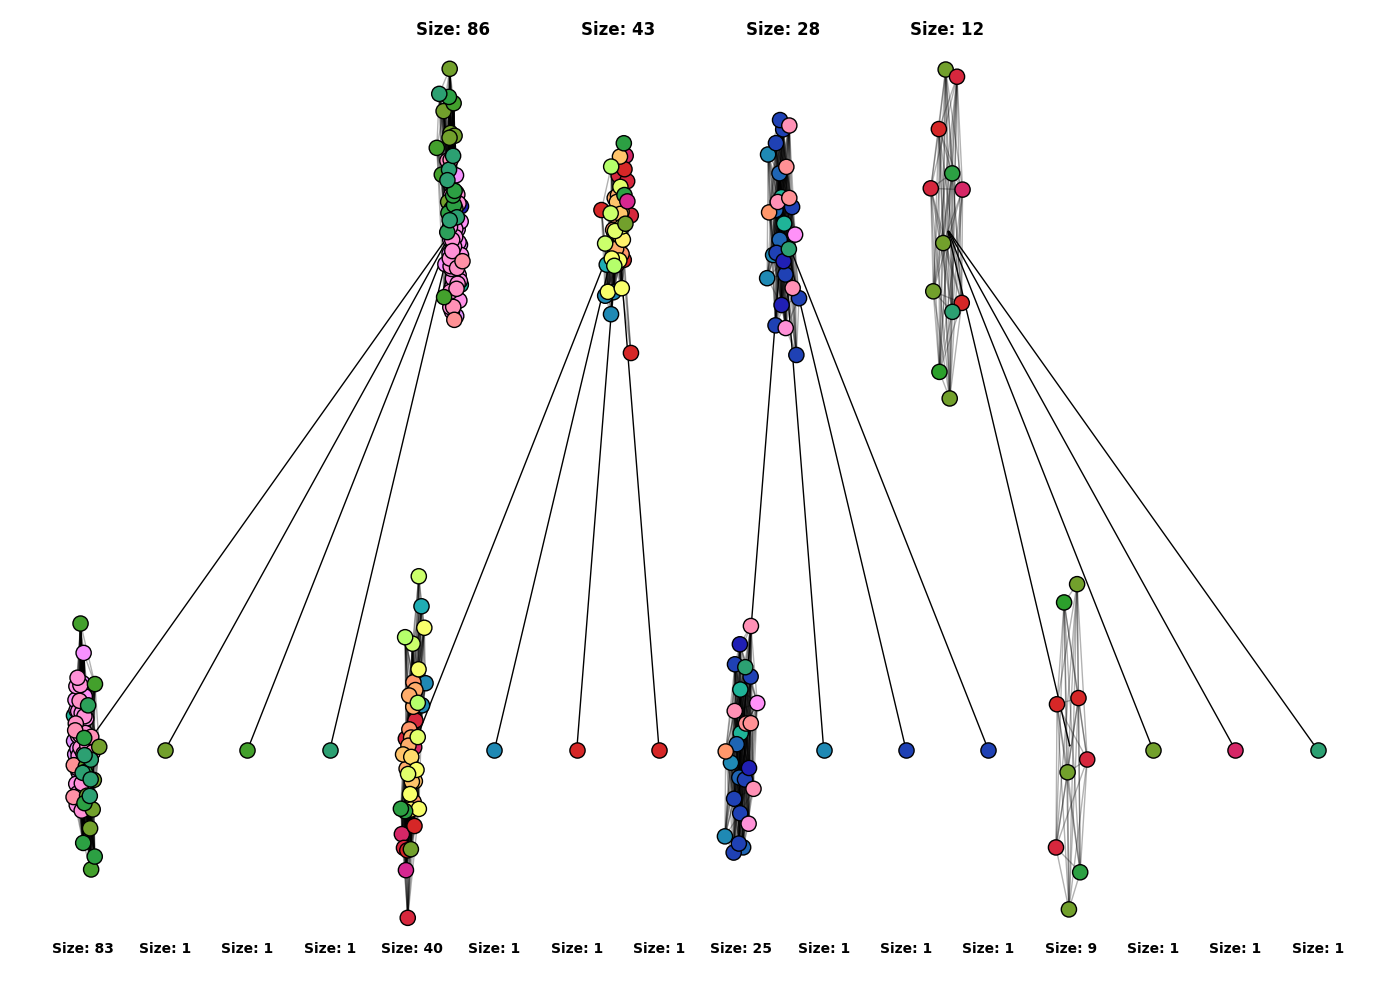

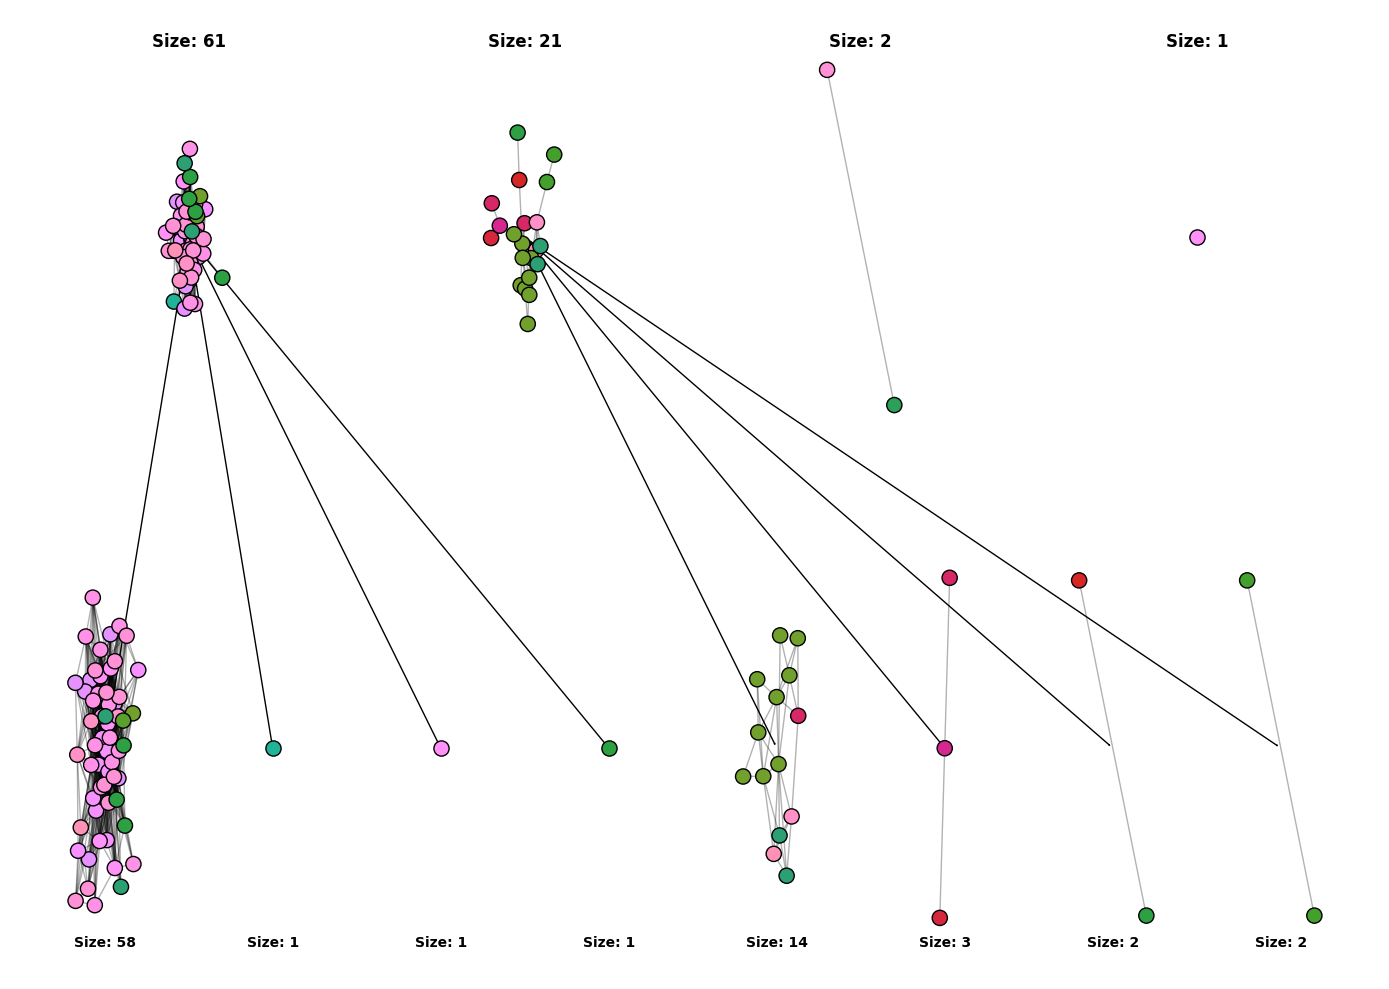

In [27]:
gn_results_list = []
for idx, (delta, graph) in enumerate(modified_graphs.items()):
	# Set gn_level based on the index
	gn_level = 1 if idx < 1 else 3

	# Run top-level community detection using Girvan-Newman algorithm
	top_level_gn = algorithms.girvan_newman(graph, level=gn_level)
	gn_eval_lvl1 = evaluate_level1_communities(delta, graph, top_level_gn)
	gn_results_list.append(gn_eval_lvl1)

	# Extract Level 2 subcommunities
	bottom_level_communities_gn, bottom_level_clustering_gn, bottom_to_top_map_gn = extract_second_level_communities(
		graph, algorithms.girvan_newman, top_level_gn, "GN", level=gn_level
	)

	# Evaluate Level 2 subcommunities
	gn_eval_lvl2 = evaluate_level2_communities(delta, graph, bottom_level_clustering_gn)
	gn_results_list.append(gn_eval_lvl2)

	# Visualize hierarchical communities
	visualize_hierarchical_communities(
		graph,
		top_level_communities=top_level_gn.communities.copy(),
		bottom_level_communities=bottom_level_communities_gn,
		bottom_to_top_map=bottom_to_top_map_gn,
		color_map=level_2_colors,
		color_by="level_2",
		title="",
		top_spacing_x=10,
	)

In [15]:
GN_results_df = format_results(pd.concat(gn_results_list, ignore_index=True))
GN_results_df

Level  Delta  Number of Communities  Nodes in Largest Community  \
0    L1   0.15                      2                         114   
1    L2   0.15                      4                         113   
2    L1   0.50                      4                          86   
3    L2   0.50                     16                          83   
4    L1   0.85                      4                          61   
5    L2   0.85                      8                          58   

                                     Community Sizes  Singletons  Modularity  \
0                                          [114, 56]           0    0.245507   
1                                    [113, 55, 1, 1]           2    0.245252   
2                                   [86, 43, 28, 12]           0    0.356301   
3  [83, 40, 25, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...          12    0.341517   
4                                     [61, 21, 2, 1]           1    0.103189   
5                         [58, 14, 3, 2, 2, 1, 1, 1]           3    0.076249   

   Closeness Centrality  ARI (L1)   RI (L1)  ARI (L2)   RI (L2)  \
0              0.810647  0.323616  0.642882       NaN       NaN   
1              0.819198       NaN       NaN  0.050803  0.487087   
2              0.814036  0.457078  0.768597       NaN       NaN   
3              0.847624       NaN       NaN  0.096293  0.699070   
4              0.556852  0.477115  0.738936       NaN       NaN   
5              0.641730       NaN       NaN  0.139421  0.576190   

                                         Communities  
0  [[0, 1, 2, 5, 11, 12, 14, 16, 17, 18, 20, 22, ...  
1  [[0, 1, 2, 5, 11, 12, 14, 16, 17, 18, 20, 22, ...  
2  [[2, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 3...  
3  [[2, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 3...  
4  [[2, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 3...  
5  [[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, ...

# Dynamic Community Detection
Using our formed network, we employ the Infomap and TILES algorithms.

## Infomap Algorithm

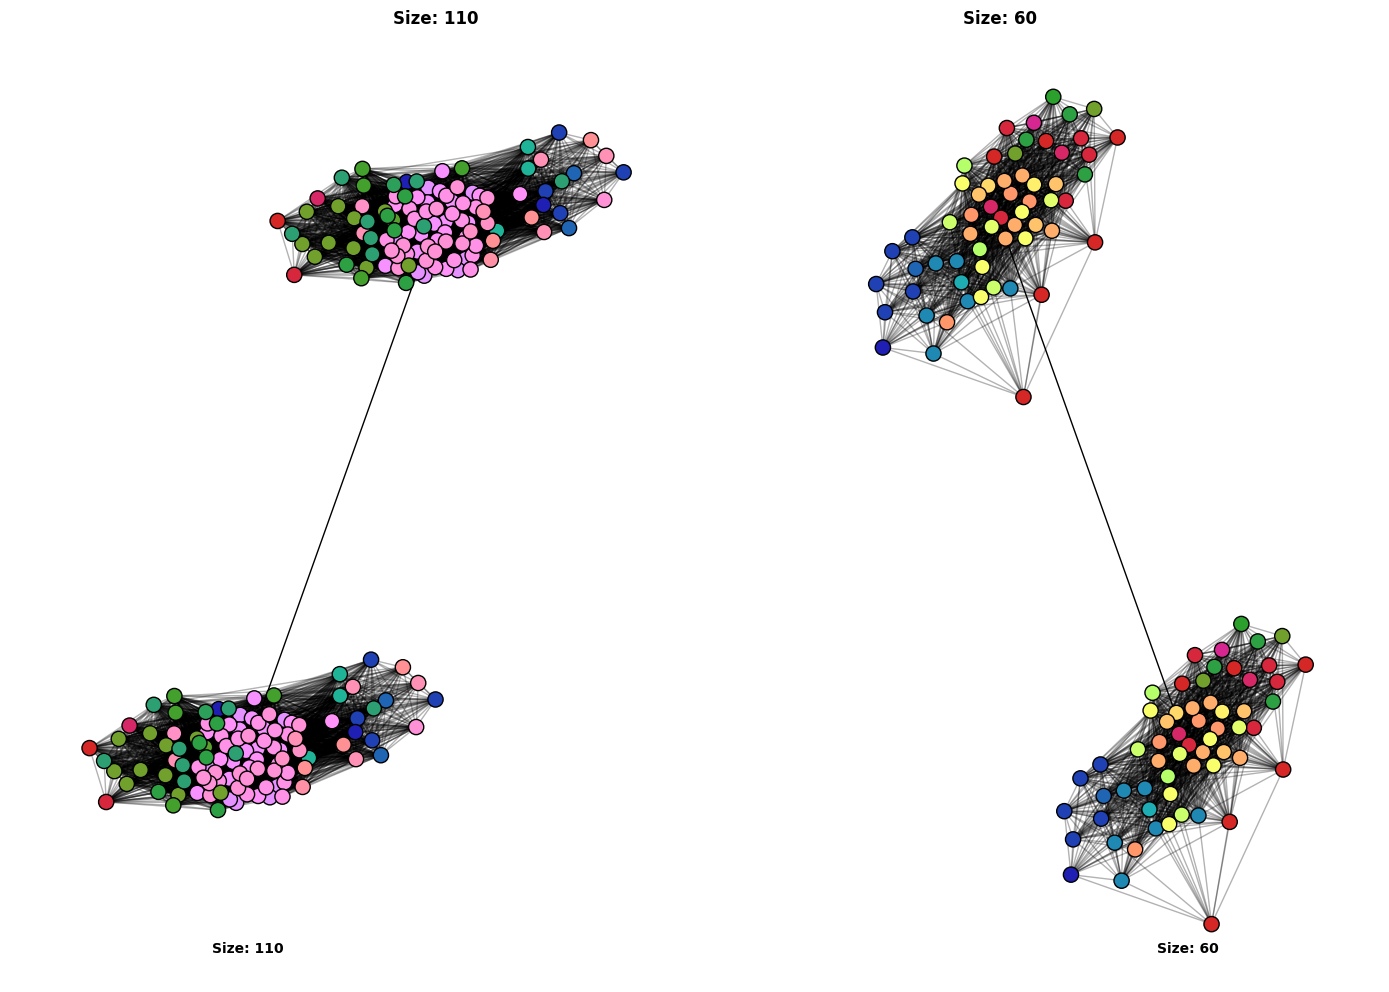

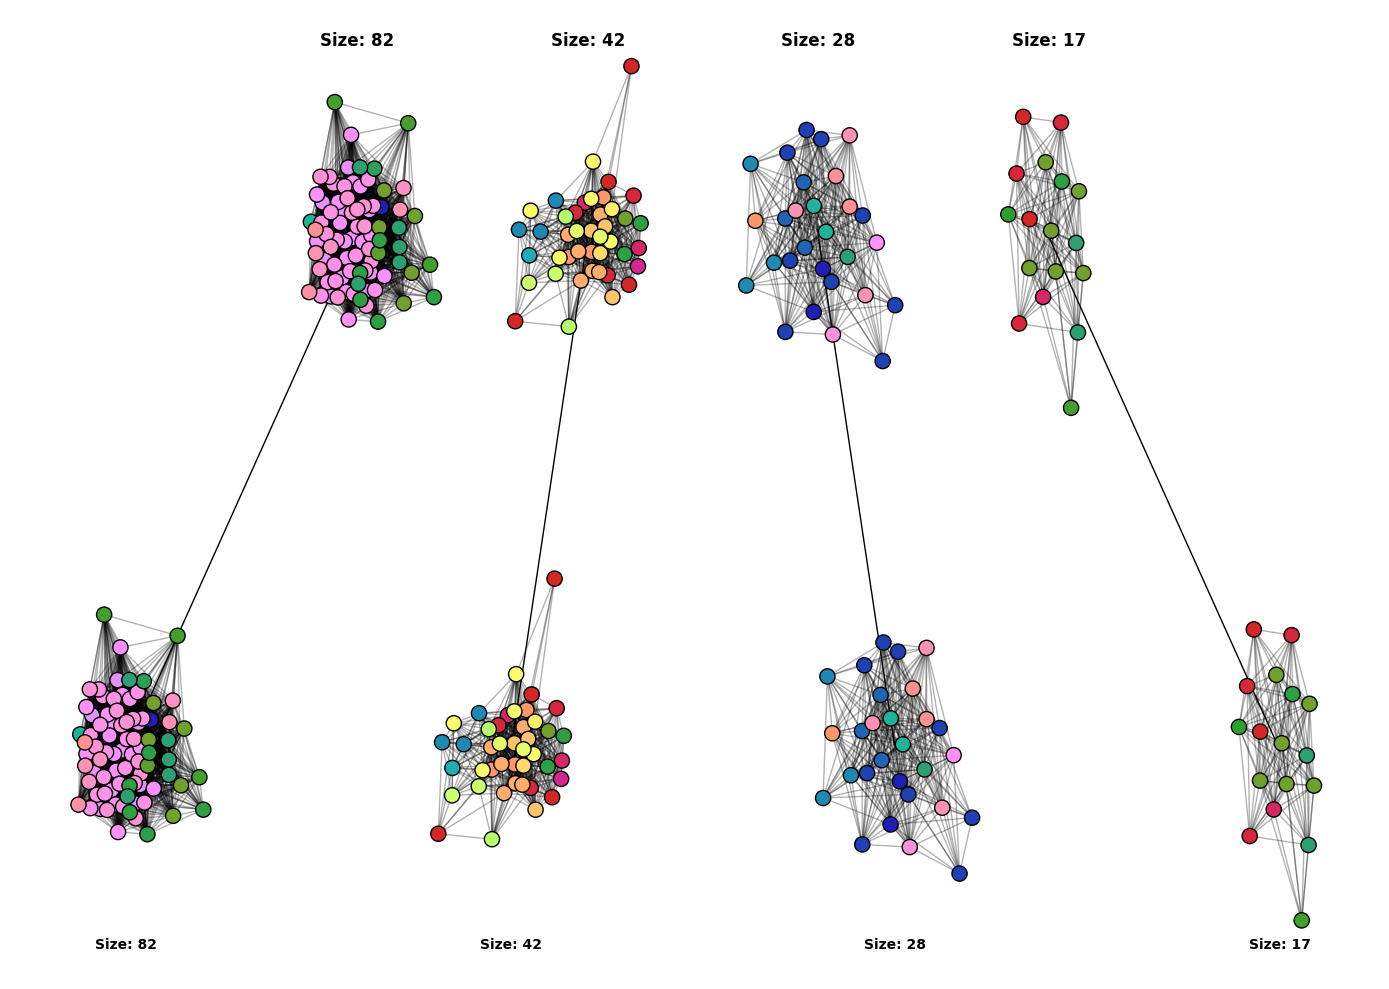

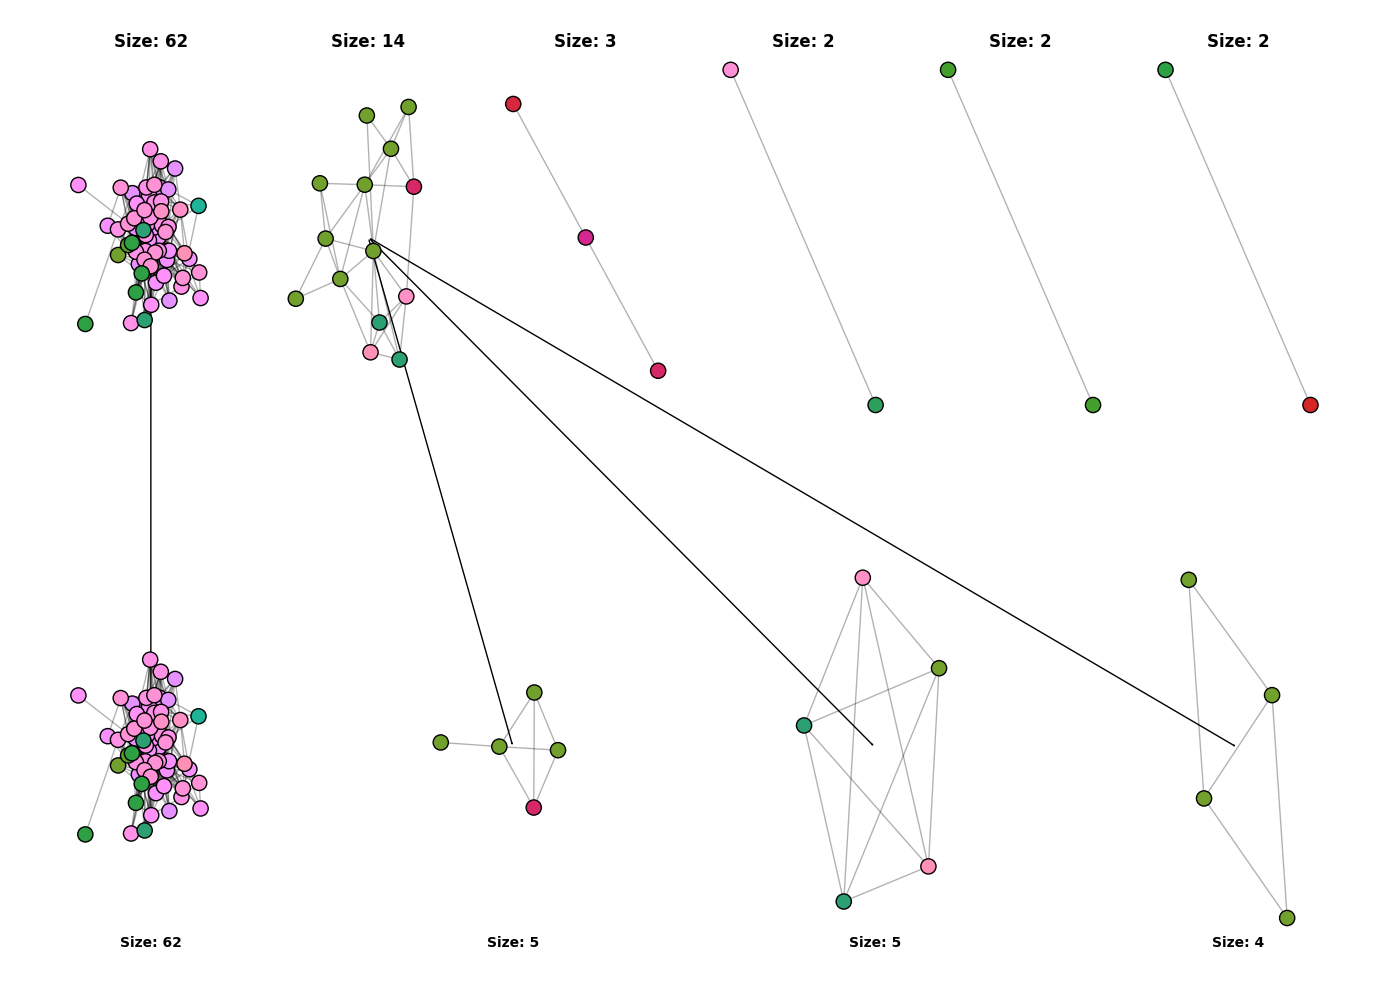

In [28]:
infomap_results_list = []

for idx, (delta, graph) in enumerate(modified_graphs.items()):
	
	top_level_infomap = algorithms.infomap(graph)
	infomap_eval_lvl1 = evaluate_level1_communities(delta, graph, top_level_infomap)
	infomap_results_list.append(infomap_eval_lvl1)


	bottom_level_communities_infomap, bottom_level_clustering_infomap, bottom_to_top_map_infomap = extract_second_level_communities(graph, algorithms.infomap, top_level_infomap, "Infomap")
	infomap_eval_lvl2 = evaluate_level2_communities(delta, graph, bottom_level_clustering_infomap)
	infomap_results_list.append(infomap_eval_lvl2)

	top_level_communities_infomap = top_level_infomap.communities.copy()
	visualize_hierarchical_communities(
			graph, 
			top_level_communities=top_level_communities_infomap, 
			bottom_level_communities=bottom_level_communities_infomap, 
			bottom_to_top_map=bottom_to_top_map_infomap, 
			color_map=level_2_colors, 
			color_by="level_2", 
			title="",
			top_spacing_x=3,
		)



In [17]:
Infomap_results_df = format_results(pd.concat(infomap_results_list, ignore_index=True))
Infomap_results_df

Level  Delta  Number of Communities  Nodes in Largest Community  \
0    L1   0.15                      2                         110   
1    L2   0.15                      2                         110   
2    L1   0.50                      4                          82   
3    L2   0.50                      4                          82   
4    L1   0.85                      6                          62   
5    L2   0.85                      4                          62   

        Community Sizes  Singletons  Modularity  Closeness Centrality  \
0             [110, 60]           0    0.258223              0.816456   
1             [110, 60]           0    0.258223              0.816456   
2      [82, 42, 28, 17]           0    0.368943              0.830865   
3      [82, 42, 28, 17]           0    0.368943              0.830865   
4  [62, 14, 3, 2, 2, 2]           0    0.100088              0.623658   
5         [62, 5, 5, 4]           0    0.068726              0.645512   

   ARI (L1)   RI (L1)  ARI (L2)   RI (L2)  \
0  0.339461  0.656248       NaN       NaN   
1       NaN       NaN  0.051593  0.490428   
2  0.475556  0.782122       NaN       NaN   
3       NaN       NaN  0.102846  0.690969   
4  0.518215  0.759384       NaN       NaN   
5       NaN       NaN  0.097743  0.514286   

                                         Communities  
0  [[0, 1, 2, 11, 12, 16, 17, 18, 20, 22, 24, 25,...  
1  [[0, 1, 2, 11, 12, 16, 17, 18, 20, 22, 24, 25,...  
2  [[2, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 3...  
3  [[2, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 3...  
4  [[2, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 3...  
5  [[2, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 3...

## Walktrap Algorithm

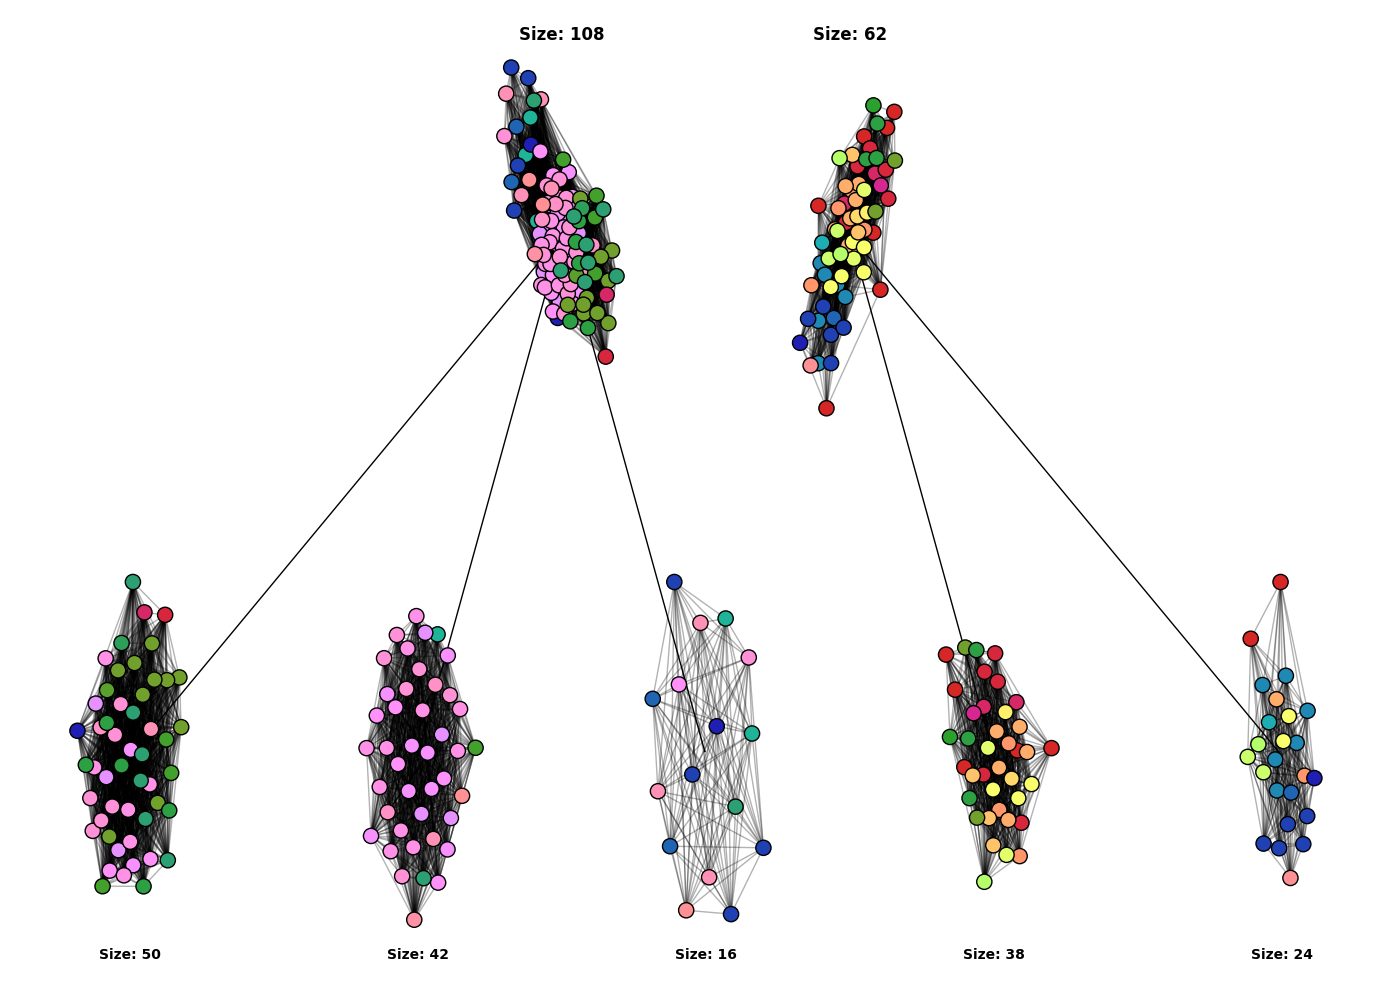

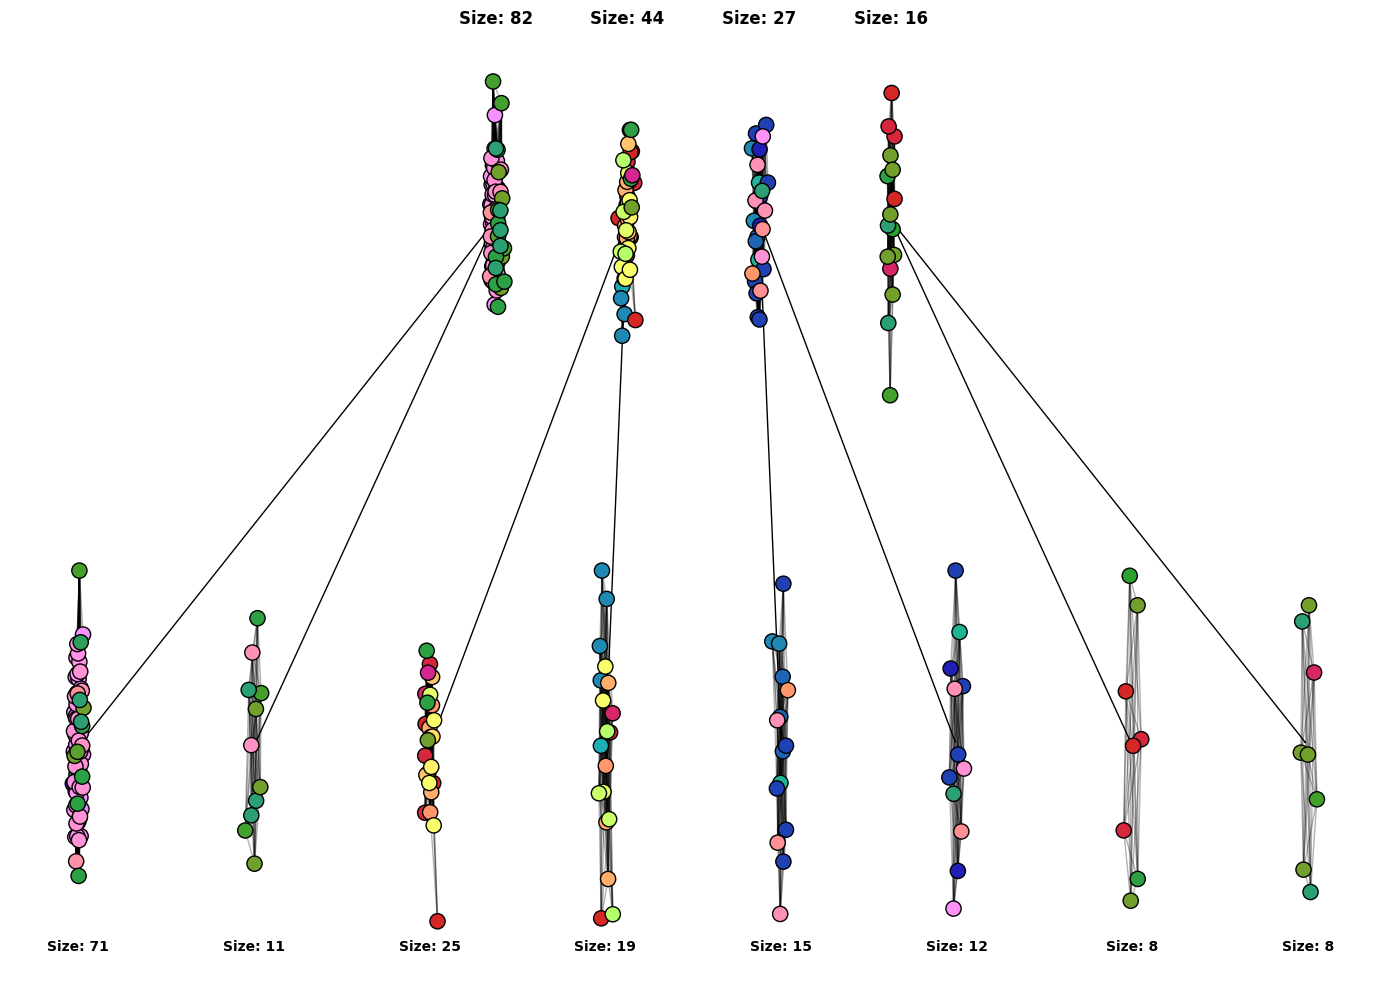

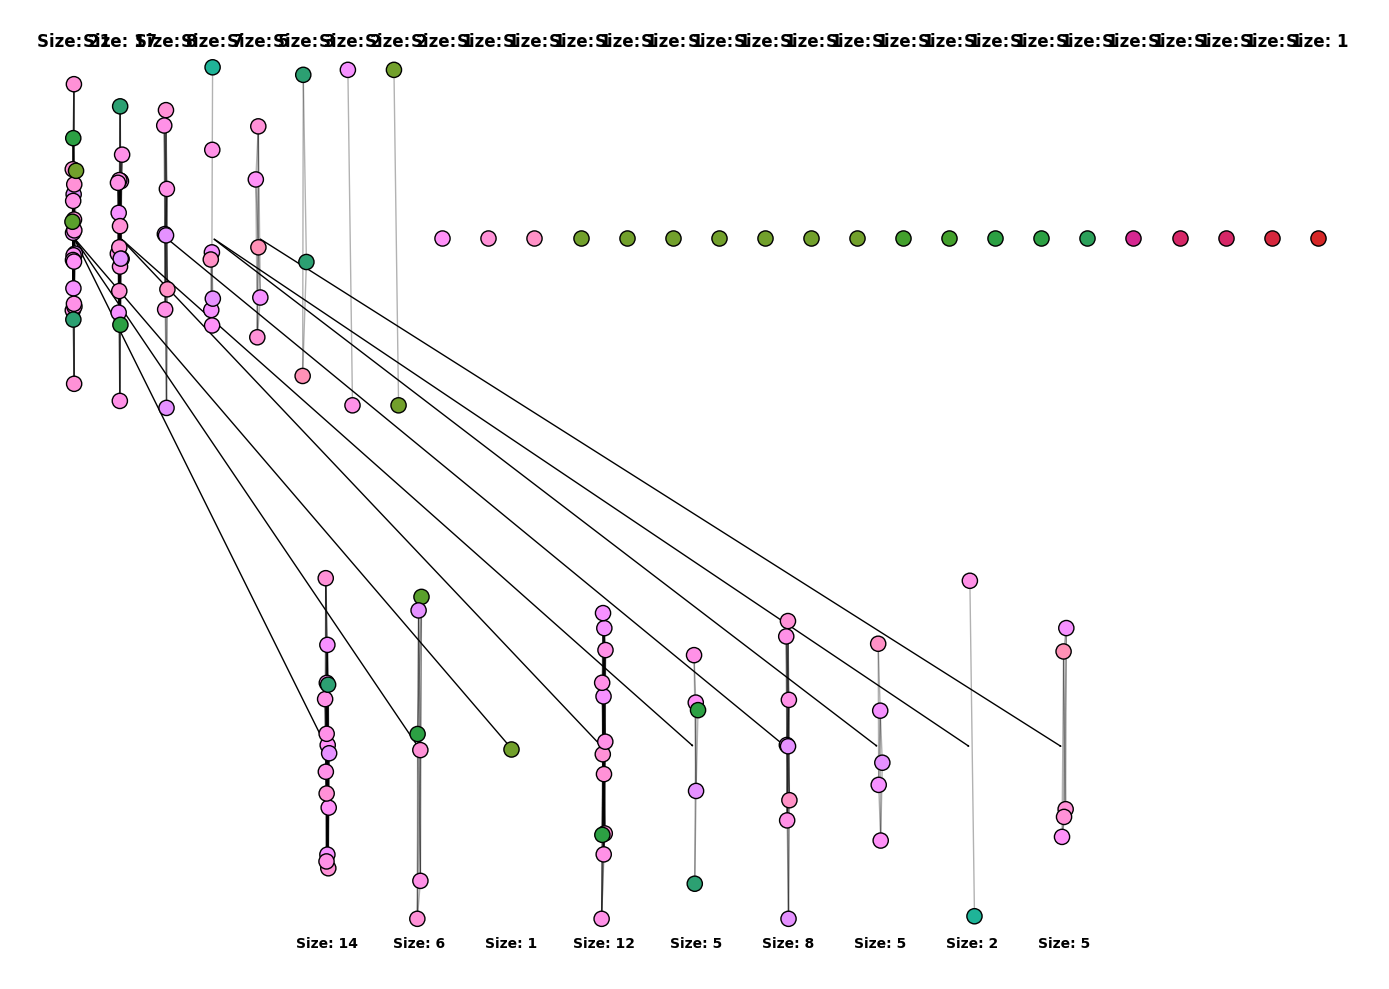

In [ ]:
walktrap_results_list = []

for idx, (delta, graph) in enumerate(modified_graphs.items()):
	top_level_walktrap = algorithms.walktrap(graph)
	walktrap_eval_lvl1 = evaluate_level1_communities(delta, graph, top_level_walktrap)
	walktrap_results_list.append(walktrap_eval_lvl1)
	
	bottom_level_communities_walktrap, bottom_level_clustering_walktrap, bottom_to_top_map_walktrap = extract_second_level_communities(graph, algorithms.walktrap, top_level_walktrap, "Walktrap")
	walktrap_eval_lvl2 = evaluate_level2_communities(delta, graph, bottom_level_clustering_walktrap)
	walktrap_results_list.append(walktrap_eval_lvl2)

	top_level_communities_walktrap = top_level_walktrap.communities.copy()
	
	if idx == 0:
		figure_size = (14, 10)
		top_spacing_x = 5
		bottom_spacing_x = 5
		show_text = True
	elif idx == 1:
		figure_size = (20, 10)
		top_spacing_x = 15
		bottom_spacing_x = 20
		show_text = True
	else:
		figure_size = (40, 10)
		top_spacing_x = 20
		bottom_spacing_x = 40
		show_text = False
	visualize_hierarchical_communities(
			graph, 
			top_level_communities=top_level_communities_walktrap, 
			bottom_level_communities=bottom_level_communities_walktrap, 
			bottom_to_top_map=bottom_to_top_map_walktrap, 
			color_map=level_2_colors, 
			color_by="level_2",
			# figure_size=figure_size, 
			top_spacing_x=top_spacing_x,
			bottom_spacing_x=bottom_spacing_x,
			show_text=show_text,
		)

In [19]:
Walktrap_results_df = format_results(pd.concat(walktrap_results_list, ignore_index=True))
Walktrap_results_df

Level  Delta  Number of Communities  Nodes in Largest Community  \
0    L1   0.15                      2                         108   
1    L2   0.15                      5                          50   
2    L1   0.50                      4                          82   
3    L2   0.50                      8                          71   
4    L1   0.85                     28                          21   
5    L2   0.85                      9                          14   

                                     Community Sizes  Singletons  Modularity  \
0                                          [108, 62]           0    0.262891   
1                               [50, 42, 38, 24, 16]           0    0.245580   
2                                   [82, 44, 27, 16]           0    0.367827   
3                     [71, 25, 19, 15, 12, 11, 8, 8]           0    0.309972   
4  [21, 17, 8, 7, 5, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1...          20    0.130078   
5                      [14, 12, 8, 6, 5, 5, 5, 2, 1]           1    0.048188   

   Closeness Centrality  ARI (L1)   RI (L1)  ARI (L2)   RI (L2)  \
0              0.818093  0.333548  0.655412       NaN       NaN   
1              0.972062       NaN       NaN  0.098152  0.779882   
2              0.827232  0.467279  0.777895       NaN       NaN   
3              0.927154       NaN       NaN  0.132016  0.782967   
4              0.820426  0.094429  0.543697       NaN       NaN   
5              0.895361       NaN       NaN  0.059718  0.787955   

                                         Communities  
0  [[0, 1, 2, 11, 12, 16, 17, 18, 20, 22, 24, 25,...  
1  [[24, 28, 29, 31, 33, 40, 43, 48, 53, 58, 61, ...  
2  [[2, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 3...  
3  [[2, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 3...  
4  [[28, 29, 35, 37, 42, 43, 45, 50, 53, 54, 58, ...  
5  [[29, 35, 37, 42, 43, 45, 50, 54, 58, 62, 68, ...

## Spinglass Algorithm

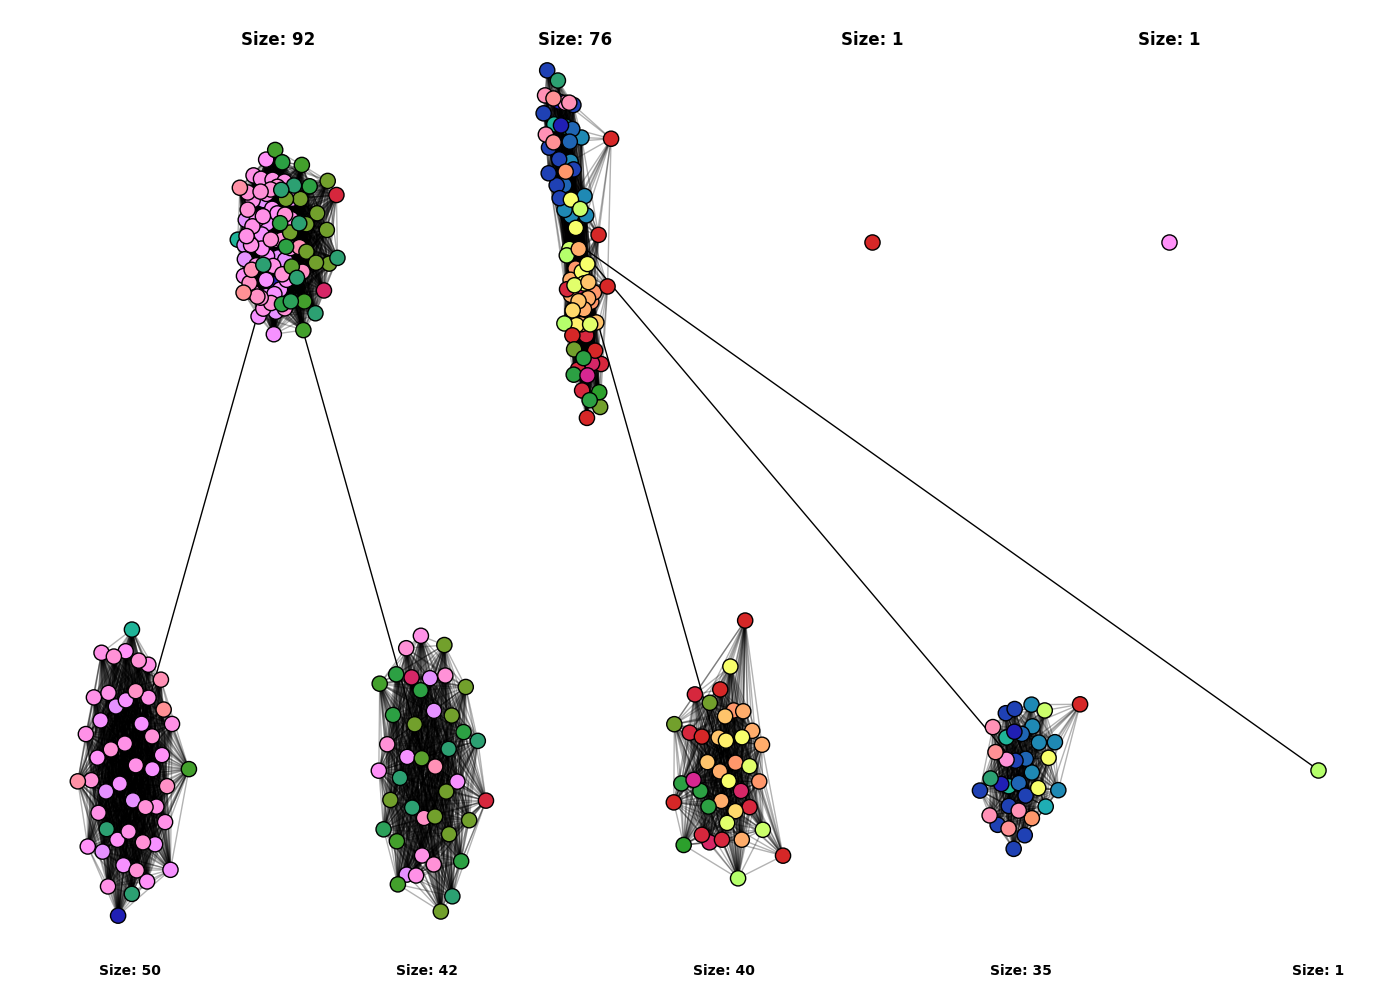

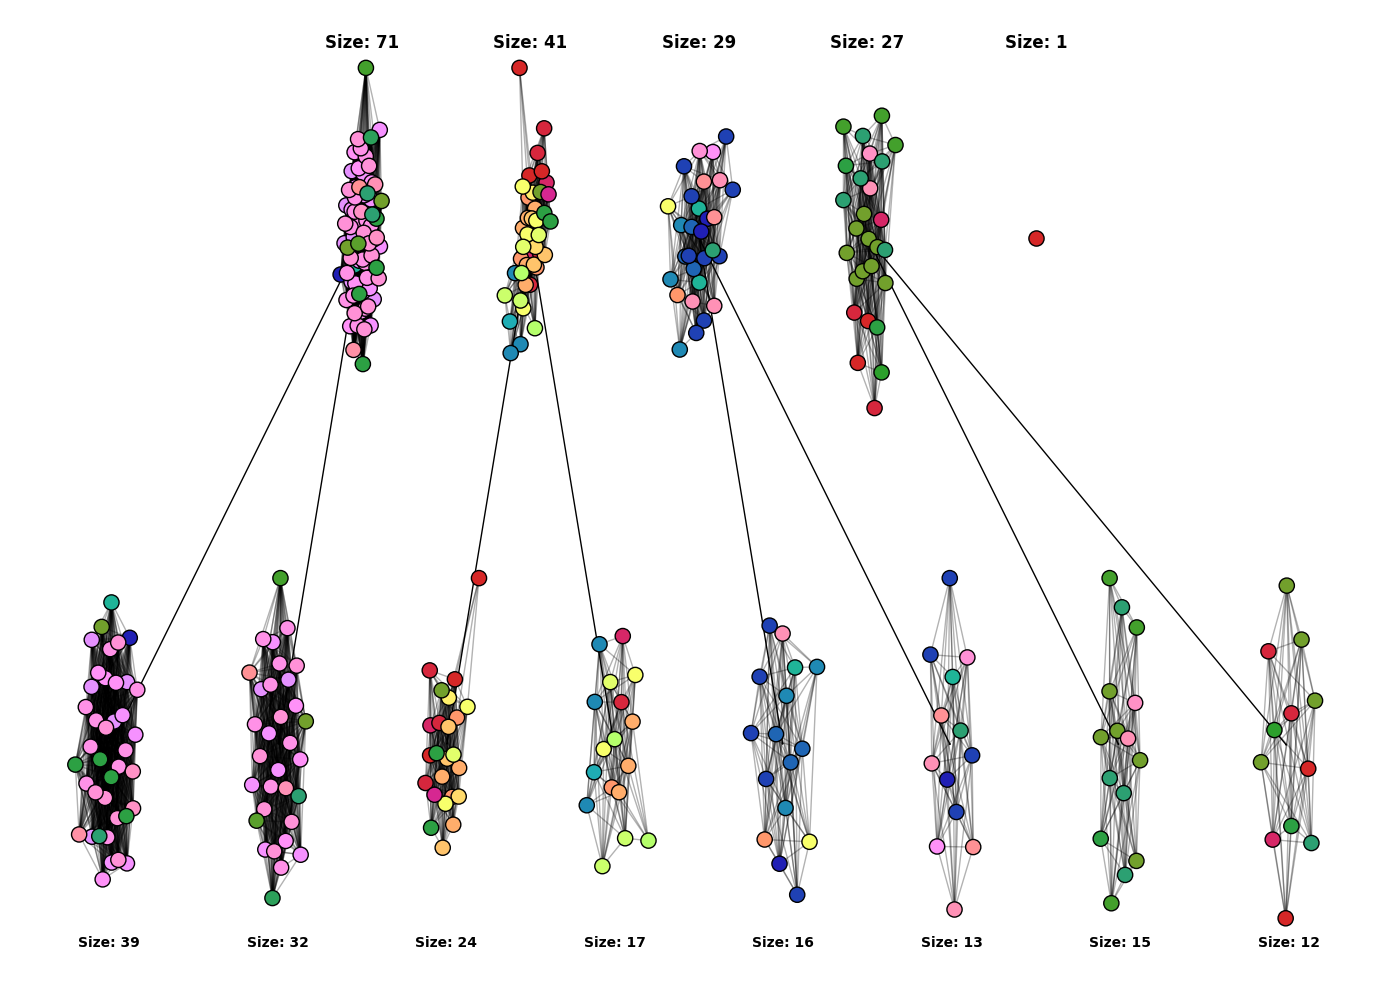

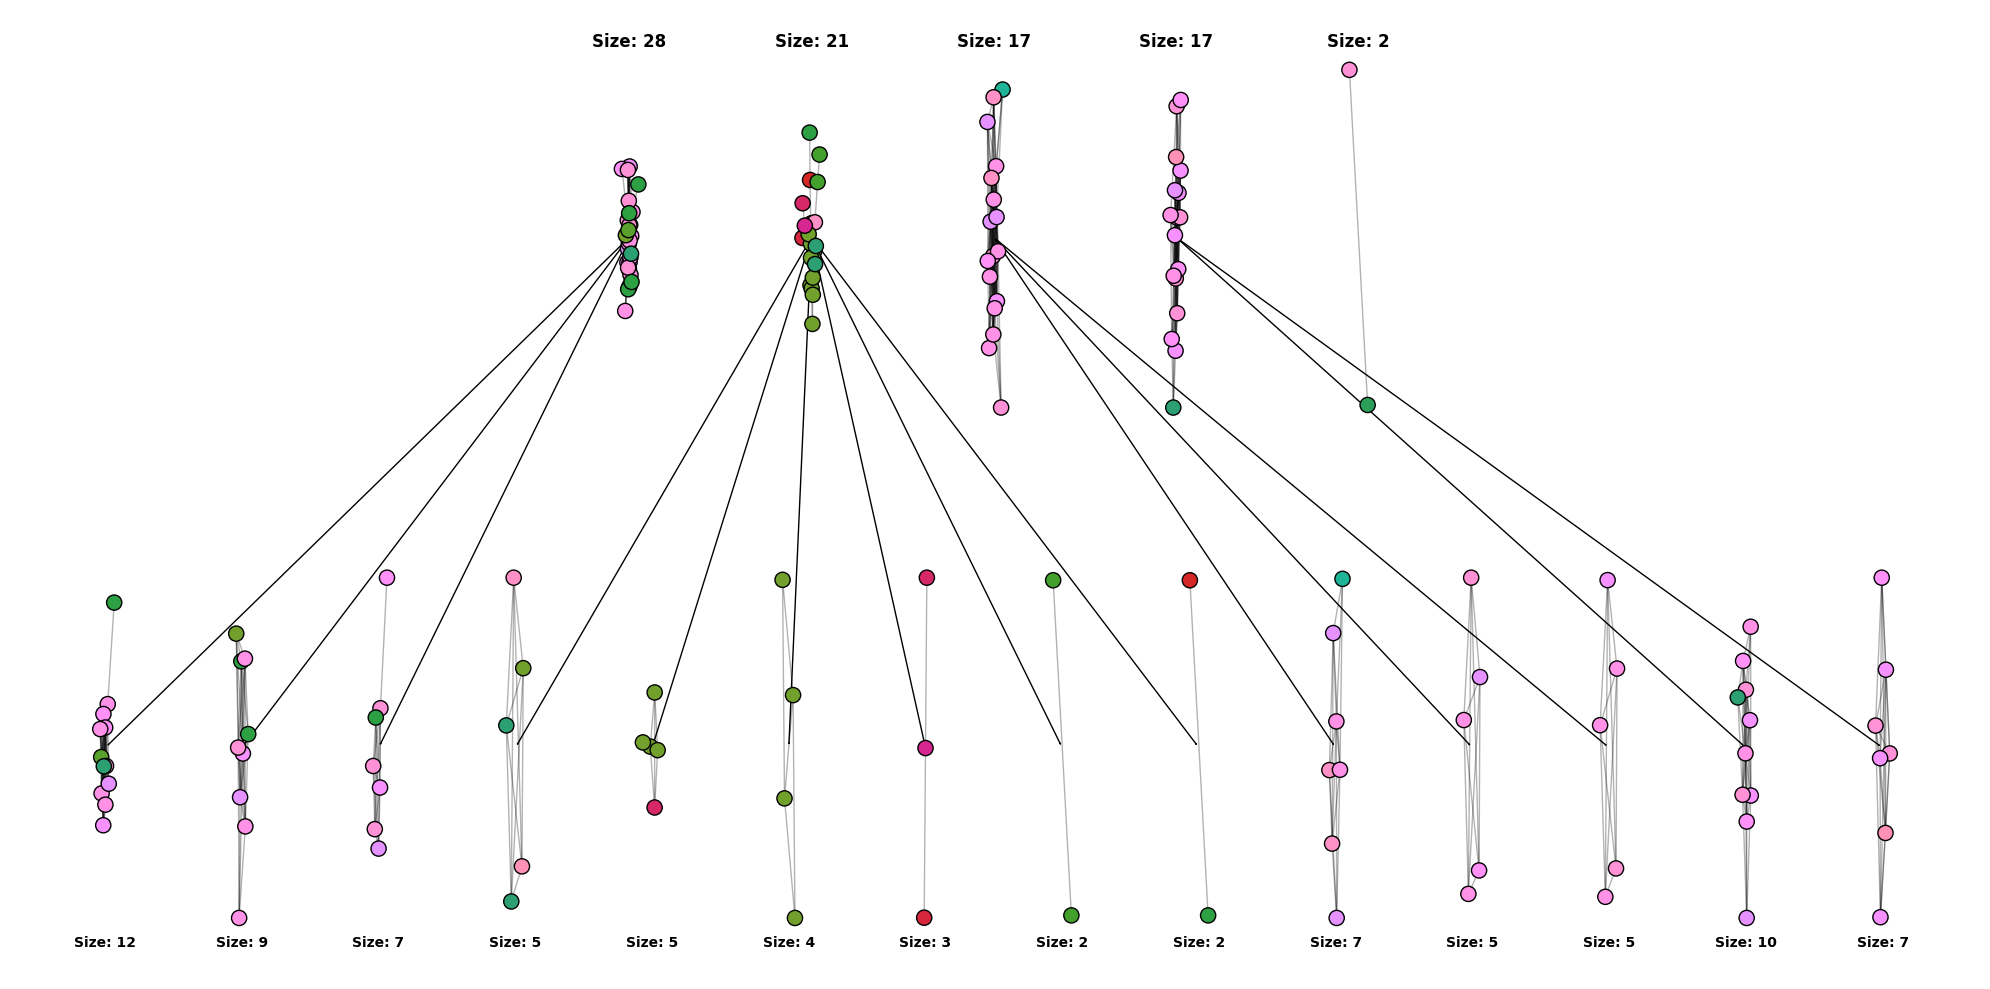

In [37]:
spinglass_results_list = []

for idx, (delta, graph) in enumerate(modified_graphs.items()):
	top_level_spinglass = algorithms.spinglass(graph)
	spinglass_eval_lvl1 = evaluate_level1_communities(delta, graph, top_level_spinglass)
	spinglass_results_list.append(spinglass_eval_lvl1)

	bottom_level_communities_spinglass, bottom_level_clustering_spinglass, bottom_to_top_map_spinglass = extract_second_level_communities(graph, algorithms.spinglass, top_level_spinglass, "Spinglass")
	spinglass_eval_lvl2 = evaluate_level2_communities(delta, graph, bottom_level_clustering_spinglass)
	spinglass_results_list.append(spinglass_eval_lvl2)
	
	top_level_communities_spinglass = top_level_spinglass.communities.copy()
	if idx < 2:
		figure_size = (14, 10)
		top_spacing_x = 5
		bottom_spacing_x = 5
		show_text = True
	else:
		figure_size = (20, 10)
		top_spacing_x = 20
		bottom_spacing_x = 15
		show_text = True
	visualize_hierarchical_communities(
			graph, 
			top_level_communities=top_level_communities_spinglass, 
			bottom_level_communities=bottom_level_communities_spinglass, 
			bottom_to_top_map=bottom_to_top_map_spinglass, 
			color_map=level_2_colors, 
			color_by="level_2", 
			figure_size=figure_size,
			top_spacing_x=top_spacing_x,
			bottom_spacing_x=bottom_spacing_x,
			show_text=show_text,
			title="",
		)


In [21]:
Spinglass_results_df = format_results(pd.concat(spinglass_results_list, ignore_index=True))
Spinglass_results_df

Level  Delta  Number of Communities  Nodes in Largest Community  \
0    L1   0.15                      4                          92   
1    L2   0.15                      5                          50   
2    L1   0.50                      5                          71   
3    L2   0.50                      8                          39   
4    L1   0.85                      5                          28   
5    L2   0.85                     14                          12   

                                Community Sizes  Singletons  Modularity  \
0                                [92, 76, 1, 1]           2    0.311083   
1                           [50, 42, 40, 35, 1]           1    0.034145   
2                           [71, 41, 29, 27, 1]           1    0.395177   
3              [39, 32, 24, 17, 16, 15, 13, 12]           0    0.240105   
4                           [28, 21, 17, 17, 2]           0    0.250232   
5  [12, 10, 9, 7, 7, 7, 5, 5, 5, 5, 4, 3, 2, 2]           0    0.153266   

   Closeness Centrality  ARI (L1)   RI (L1)  ARI (L2)   RI (L2)  \
0              0.829086  0.311694  0.659380       NaN       NaN   
1              0.968807       NaN       NaN  0.116431  0.768674   
2              0.857478  0.507782  0.806495       NaN       NaN   
3              0.938721       NaN       NaN  0.110825  0.847915   
4              0.648310  0.153996  0.574790       NaN       NaN   
5              0.879331       NaN       NaN  0.068727  0.857983   

                                         Communities  
0  [[2, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 3...  
1  [[2, 24, 25, 26, 27, 29, 32, 34, 35, 36, 37, 3...  
2  [[2, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 3...  
3  [[2, 24, 25, 26, 27, 28, 29, 32, 35, 36, 40, 4...  
4  [[28, 29, 31, 33, 37, 40, 43, 45, 48, 53, 58, ...  
5  [[29, 37, 43, 45, 53, 62, 63, 65, 75, 104, 110...

# Community Detection Results

In [22]:
Paris_results_df["Algorithm"] = "Paris"
LFM_results_df["Algorithm"] = "LFM"
GN_results_df["Algorithm"] = "Girvan-Newman"
Infomap_results_df["Algorithm"] = "Infomap"
Walktrap_results_df["Algorithm"] = "Walktrap"
Spinglass_results_df["Algorithm"] = "Spinglass"

# Combine all into one
Community_Detection_Results = pd.concat([
    Paris_results_df,
    LFM_results_df,
    GN_results_df,
    Infomap_results_df,
    Walktrap_results_df,
    Spinglass_results_df
], axis=0)

# Reorder so "Algorithm" is the first column and "Communities" is last
columns_order = [col for col in Community_Detection_Results.columns if col not in ["Algorithm", "Communities"]]
columns_order = ["Algorithm"] + columns_order + ["Communities"]
Community_Detection_Results = Community_Detection_Results[columns_order]


# Save separate CSVs per Delta
output_dir = "../results/cho-170/community_detection_results_by_delta"
os.makedirs(output_dir, exist_ok=True)

# Group by Delta and save each one
for delta_value, group_df in Community_Detection_Results.groupby("Delta"):
    delta_filename = f"{output_dir}/cho-170_cd_results_delta_{delta_value:.2f}.csv"
    group_df.to_csv(delta_filename, index=False)

Community_Detection_Results

Algorithm Level  Delta  Number of Communities  \
0          Paris    L1   0.15                      3   
1          Paris    L2   0.15                      7   
2          Paris    L1   0.50                      2   
3          Paris    L2   0.50                      4   
4          Paris    L1   0.85                      2   
5          Paris    L2   0.85                      8   
0            LFM    L1   0.15                      5   
1            LFM    L2   0.15                     65   
2            LFM    L1   0.50                      3   
3            LFM    L2   0.50                      7   
4            LFM    L1   0.85                      4   
5            LFM    L2   0.85                      2   
0  Girvan-Newman    L1   0.15                      2   
1  Girvan-Newman    L2   0.15                      4   
2  Girvan-Newman    L1   0.50                      4   
3  Girvan-Newman    L2   0.50                     16   
4  Girvan-Newman    L1   0.85                      4   
5  Girvan-Newman    L2   0.85                      8   
0        Infomap    L1   0.15                      2   
1        Infomap    L2   0.15                      2   
2        Infomap    L1   0.50                      4   
3        Infomap    L2   0.50                      4   
4        Infomap    L1   0.85                      6   
5        Infomap    L2   0.85                      4   
0       Walktrap    L1   0.15                      2   
1       Walktrap    L2   0.15                      5   
2       Walktrap    L1   0.50                      4   
3       Walktrap    L2   0.50                      8   
4       Walktrap    L1   0.85                     28   
5       Walktrap    L2   0.85                      9   
0      Spinglass    L1   0.15                      4   
1      Spinglass    L2   0.15                      5   
2      Spinglass    L1   0.50                      5   
3      Spinglass    L2   0.50                      8   
4      Spinglass    L1   0.85                      5   
5      Spinglass    L2   0.85                     14   

   Nodes in Largest Community  \
0                          76   
1                          37   
2                          98   
3                          71   
4                          64   
5                          20   
0                         170   
1                         170   
2                         100   
3                         100   
4                          64   
5                          64   
0                         114   
1                         113   
2                          86   
3                          83   
4                          61   
5                          58   
0                         110   
1                         110   
2                          82   
3                          82   
4                          62   
5                          62   
0                         108   
1                          50   
2                          82   
3                          71   
4                          21   
5                          14   
0                          92   
1                          50   
2                          71   
3                          39   
4                          28   
5                          12   

                                     Community Sizes  Singletons  Modularity  \
0                                       [76, 65, 29]           0    0.321865   
1                       [37, 34, 28, 24, 18, 15, 14]           0    0.217234   
2                                           [98, 71]           0    0.317191   
3                                   [71, 45, 27, 26]           0    0.386131   
4                                           [64, 21]           0    0.100972   
5                       [20, 16, 14, 14, 7, 7, 4, 3]           0    0.226944   
0                              [170, 77, 77, 77, 77]           0    0.311106   
1  [170, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, ...           0    0.31

# Results Visualization

In [23]:
# Prepare a function to generate bar plots for ARI (L1) and RI (L1) or ARI (L2) and RI (L2)
def plot_metric_by_delta(results_df, metrics, level_title_suffix):
    unique_deltas = sorted(results_df["Delta"].dropna().unique())
    for delta in unique_deltas:
        subset_df = results_df[(results_df["Delta"] == delta) & (results_df["Level"] == level_title_suffix)]
        
        if subset_df.empty:
            continue

        labels = subset_df["Algorithm"]
        x = np.arange(len(labels))
        width = 0.2

        fig, ax = plt.subplots(figsize=(10, 6))
        offsets = np.linspace(-0.5, 0.5, num=len(metrics))

        for metric, offset in zip(metrics, offsets):
            if metric not in subset_df.columns:
                continue
            values = subset_df[metric]
            bars = ax.bar(x + offset * width, values, width, label=metric)
            ax.bar_label(bars, fmt='%.3f', padding=3, fontsize=8)

        ax.set_ylabel('Score')
        ax.set_title(f"{' and '.join(metrics)} for Cho-170 Network (delta = {delta}, Level = {level_title_suffix})")
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=15)
        ax.set_ylim(0, 1)
        ax.legend()
        plt.tight_layout()
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.show()

## Level 1 Classification Score

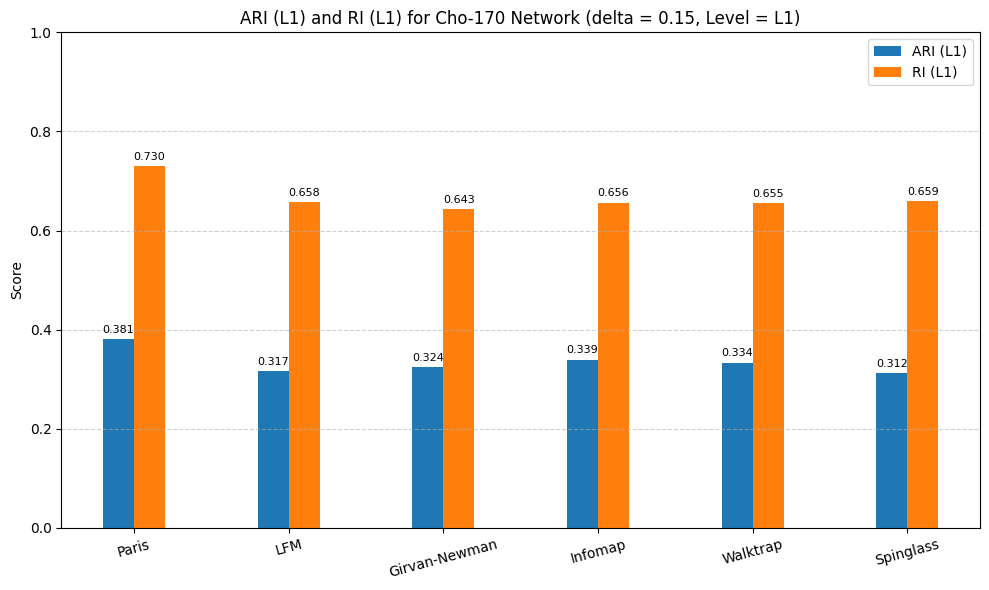

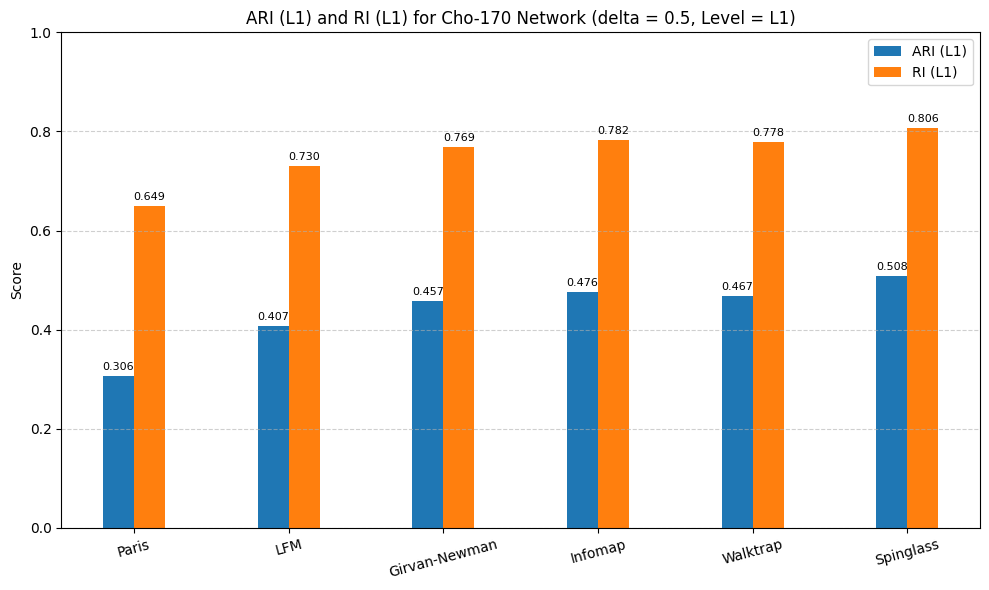

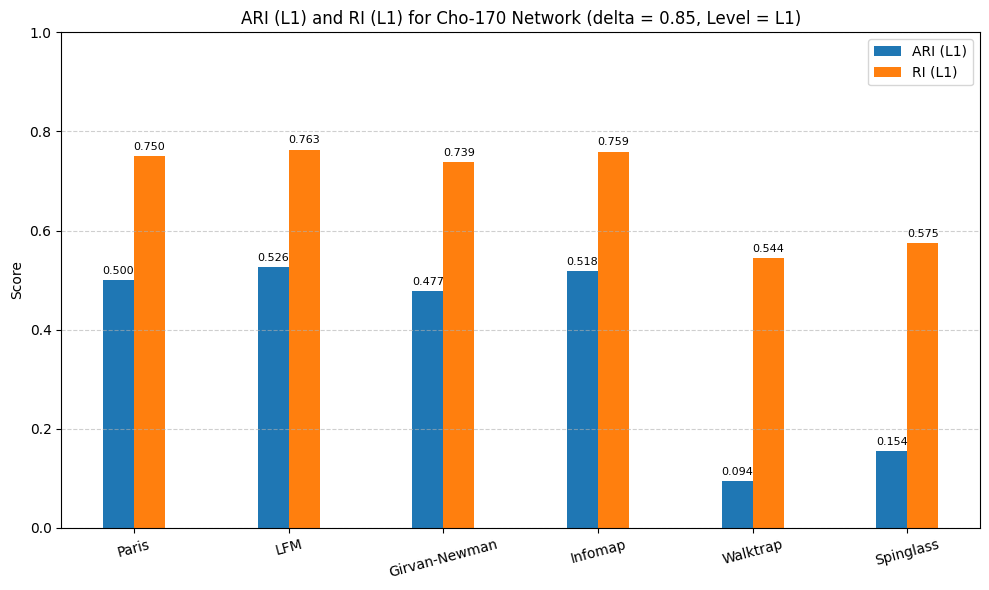

In [24]:
# Plot ARI and RI for Level 1
plot_metric_by_delta(Community_Detection_Results, metrics=["ARI (L1)", "RI (L1)"], level_title_suffix="L1")

## Level 2 Classification Score

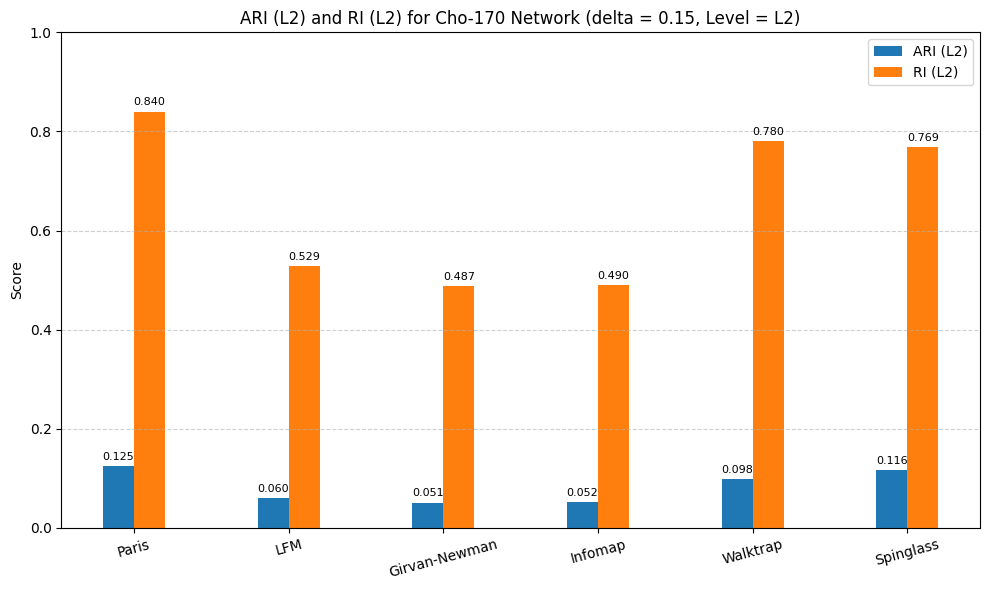

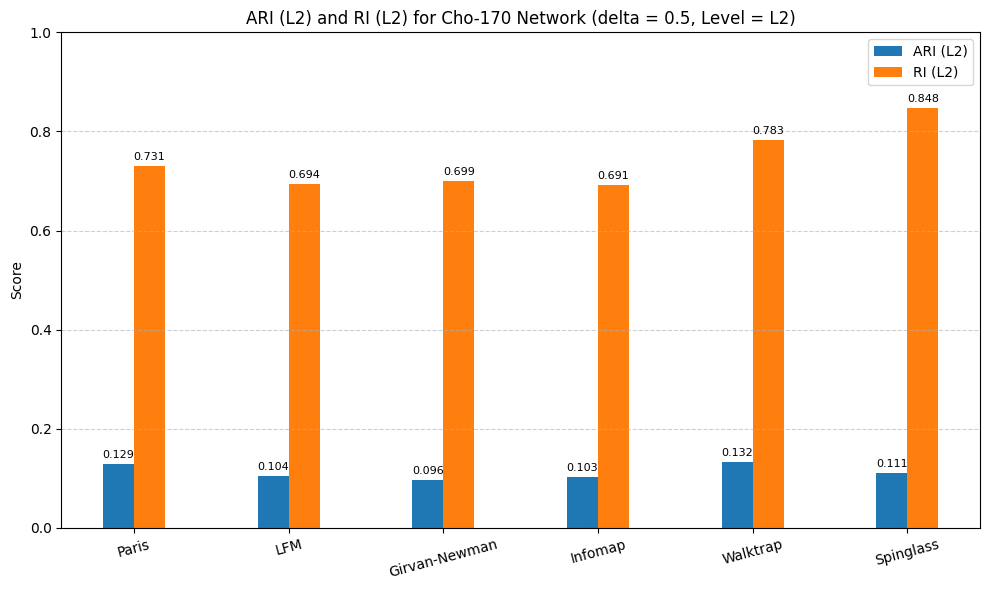

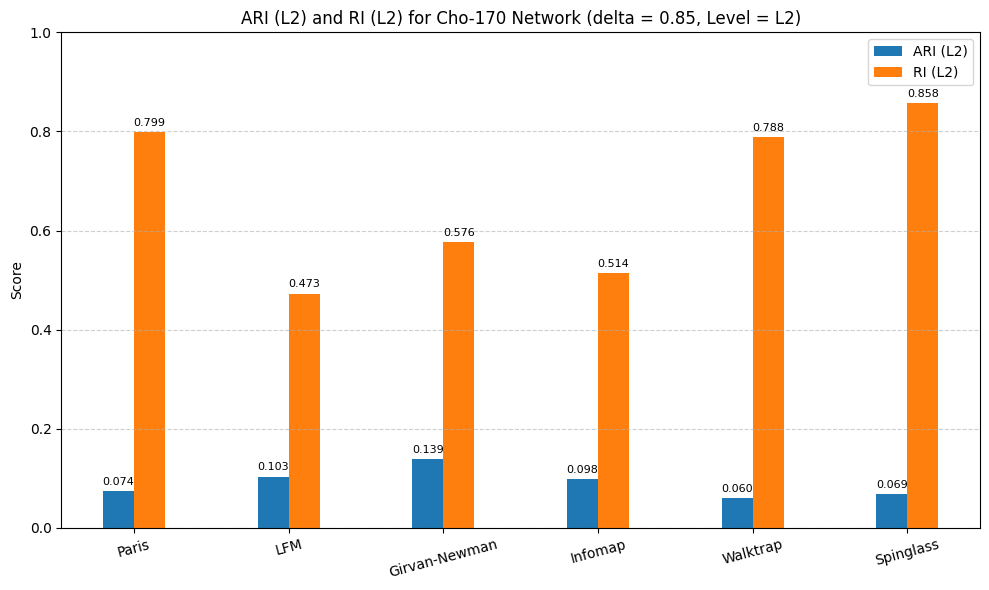

In [25]:
# Plot ARI and RI for Level 2
plot_metric_by_delta(Community_Detection_Results, metrics=["ARI (L2)", "RI (L2)"], level_title_suffix="L2")